In [1]:
# Librerias necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from sklearn.metrics import jaccard_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

C:\Users\Usuario\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [ ]:
#Importación de dataset desde github
url = 'https://github.com/ISPC-PP1-2024/proyecto/blob/main/datos/DataCoSupplyChainDataset/DataCoSupplyChainDataset.csv'
df_1 = pd.read_csv(url)

In [2]:
# Se consulta la base de datos
df_1=pd.read_csv('C:\\Users\\Usuario\\Desktop\\2024\\materias\\CDIA\\2semestre\\pp1-cdia23\\ejemplo suply chain\\DataCoSupplyChainDataset.csv\\para jupyter\\DataCoSupplyChainDataset.csv', encoding='latin1', sep=',',  low_memory=False)

In [3]:
# filtramos el set de datos original por país para abarcar solo argentina, brasil y mexico
df = df_1[df_1['Order Country'].isin(['Argentina', 'Brasil', 'Mexico'])]

In [4]:
df_1.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [5]:
# verificamos si existen filas duplicadas
duplicados=df[df.duplicated()]
if duplicados.empty:
    print("No hay filas duplicadas en el DataFrame.")
else:
    print("Las siguientes filas están duplicadas:")
    print(duplicados)

No hay filas duplicadas en el DataFrame.


In [6]:
# verificamos si tenemos valores vacíos
hay_vacios = df.isna().any().any()

if hay_vacios:
    print("El DataFrame contiene valores vacíos.")
else:
    print("El DataFrame no contiene valores vacíos.")

El DataFrame contiene valores vacíos.


In [7]:
#Buscamos valores negativos en las columnas y mostramos si alguna los tiene
def check_negative_values(df_1, columns):
    results = {}
    for col in columns:
        if col not in df_1.columns:
            results[col] = f"La columna '{col}' no existe en el DataFrame"
            continue
        
        # Convertir la columna a numérica, coerciendo errores a NaN
        numeric_col = pd.to_numeric(df_1[col], errors='coerce')
        
        # Contar valores negativos, excluyendo NaN
        negative_count = (numeric_col < 0).sum()
        nan_count = numeric_col.isna().sum()
        
        if negative_count > 0:
            results[col] = f"Se encontraron {negative_count} valores negativos en '{col}'"
        else:
            results[col] = f"No se encontraron valores negativos en '{col}'"
        
        if nan_count > 0:
            results[col] += f". Además, hay {nan_count} valores no numéricos o nulos"

    return results

columns_to_check = ['Order Item Quantity', 'Sales', 'Order Item Total', 'Product Price']
results = check_negative_values(df_1, columns_to_check)

# Resultados
for col, result in results.items():
    print(result)

# Información adicional sobre tipos de datos
print("\nTipos de datos de las columnas:")
for col in columns_to_check:
    if col in df_1.columns:
        print(f"{col}: {df_1[col].dtype}")
    else:
        print(f"{col}: Columna no encontrada")   

No se encontraron valores negativos en 'Order Item Quantity'
No se encontraron valores negativos en 'Sales'
No se encontraron valores negativos en 'Order Item Total'
No se encontraron valores negativos en 'Product Price'

Tipos de datos de las columnas:
Order Item Quantity: int64
Sales: float64
Order Item Total: float64
Product Price: float64


In [8]:
# quitar columnas vacias 
df = df.drop(['Product Description', 'Order Zipcode', 'Product Status'], axis=1)

In [9]:
#ELIMINAMOS COLUMNAS DEL DATAFRAME QUE NO USAMOS.
columnas_a_eliminar = ['Sales per customer','Category Id','Customer City','Customer Email','Customer Fname','Customer Lname',
'Customer Password','Customer State','Customer Street','Customer Zipcode','Department Id','Department Name','Latitude',
'Longitude','Market','Order City','Order Customer Id','Order Item Cardprod Id','Order Item Discount', 'Order Item Discount Rate',
'Order Item Profit Ratio','Product Image']

df = df.drop(columns=columnas_a_eliminar)

In [10]:
# Traducimos las columnas para facilitar el manejo y sacar los espacios
df_espanol=df
df_espanol.rename(columns={'Category Name':'Categoria',
                           'Type':'Pago'
                           ,'Days for shipping (real)':'DiasEnvio(Real)'
                           , 'Days for shipment (scheduled)':'DiasEnvio(Programado)'
                           , 'Benefit per order':'BeneficioPorPedido'
                           , 'Delivery Status':'EstadoEntrega'
                           , 'Late_delivery_risk':'RiesgoEntregaTardia'
                           , 'Category Name':'Categoria'
                           , 'Customer Country':'PaisCliente'
                           , 'Customer Id':'IDCliente'
                           , 'Customer Segment':'SegmentoCliente'
                           , 'Order Country':'PaisPedido'
                           , 'order date (DateOrders)':'FechaPedido'
                           , 'Order Id':'IDPedido'
                           , 'Order Item Id':'IDArticuloPedido'
                           , 'Order Item Product Price':'PrecioArticuloPedido'
                           , 'Order Item Quantity':'CantidadArticulosPedido'
                           , 'Sales':'Ventas'
                           , 'Order Item Total':'TotalArticulosPedido'
                           , 'Order Profit Per Order':'GananciaPorPedido'
                           , 'Order Region':'RegionPedido'
                           , 'Order State':'DestinoPedido'
                           , 'Order Status':'EstadoPedido'
                           , 'Product Card Id':'IDProducto'
                           , 'Product Category Id':'CategoriaProducto'
                           , 'Product Name':'NombreProducto'
                           , 'Product Price':'PrecioProducto'
                           , 'shipping date (DateOrders)':'FechaEnvio'
                           , 'Shipping Mode':'ModoEnvio'                                
                          
                          },inplace=True)

In [12]:
#utilizar cada uno de estos dataframes para cada ejemplo, para evitar variaciones en el desarrollo
df_lineal=df_logistica=df_arbol=df_cluster=df_espanol

# Comenzamos con la regresión lineal simple

In [13]:
# Veamos solo las columnas numéricas del DataFrame para analizar cuáles trabajaremos
columnas_numericas = df_lineal.select_dtypes(include=['number'])
columnas_numericas.columns

Index(['DiasEnvio(Real)', 'DiasEnvio(Programado)', 'BeneficioPorPedido',
       'RiesgoEntregaTardia', 'IDCliente', 'IDPedido', 'IDArticuloPedido',
       'PrecioArticuloPedido', 'CantidadArticulosPedido', 'Ventas',
       'TotalArticulosPedido', 'GananciaPorPedido', 'IDProducto',
       'CategoriaProducto', 'PrecioProducto'],
      dtype='object')

Vamos a realizar la regresión lineal entre:<br>
Ventas y Ganancia Por Pedido

In [14]:
df_lineal[['Ventas','GananciaPorPedido']].head()

,Ventas,GananciaPorPedido
84,150.000000,23.469999
91,119.970001,32.860001
93,199.949997,55.090000
94,199.949997,68.589996
95,250.000000,51.980000


In [15]:
#Trabajamos los valores de las columnas
import re

# Creamos una función para limpiar los datos
def clean(benPP_str):
    if pd.isna(benPP_str):
        return None
    
    # Convertir a string si no lo es
    benPP_str = str(benPP_str)
    
    # Eliminar espacios en blanco y caracteres no numéricos excepto punto y coma
    cleaned = re.sub(r'[^\d.,]', '', benPP_str)
    
    # Reemplazar coma por punto si hay más de un punto (asumiendo que la coma es el separador decimal)
    if cleaned.count('.') > 1 and ',' in cleaned:
        cleaned = cleaned.replace(',', '.')
    
    # Si hay más de un punto, asumimos que todos menos el último son separadores de miles
    parts = cleaned.split('.')
    if len(parts) > 2:
        integer_part = ''.join(parts[:-1])
        decimal_part = parts[-1]
        cleaned = f"{integer_part}.{decimal_part}"
    
    try:
        return float(cleaned)
    except ValueError:
        print(f"No se pudo convertir: {benPP_str}")
        return None

# Aplicamos la función a la columna Beneficio
df_lineal['Ventas'] = df_lineal['Ventas'].apply(clean)

# Aplicamos la función a la columna Ganancia
df_lineal['GananciaPorPedido'] = df_lineal['GananciaPorPedido'].apply(clean)

Graficamos la relación

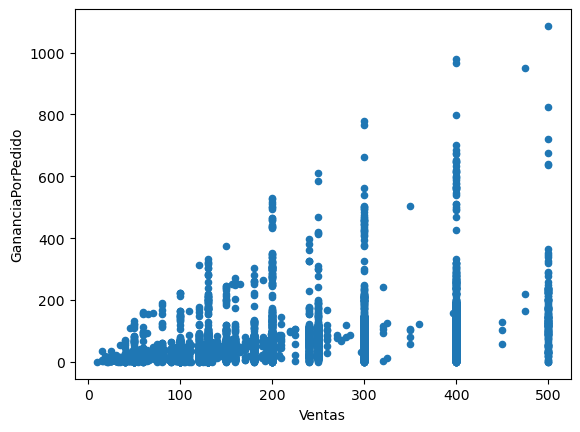

In [16]:
df_lineal.plot.scatter(x='Ventas', y='GananciaPorPedido')
plt.show()

# Recta lineal
La ecuación de la recta lineal es: y=wx+b donde w:pendiente y b:intercepto

# Agreguemos una recta sobre unestra gráfica

In [17]:
#Establecemos los valores de los parámetros de la recta:
w=1
b=0

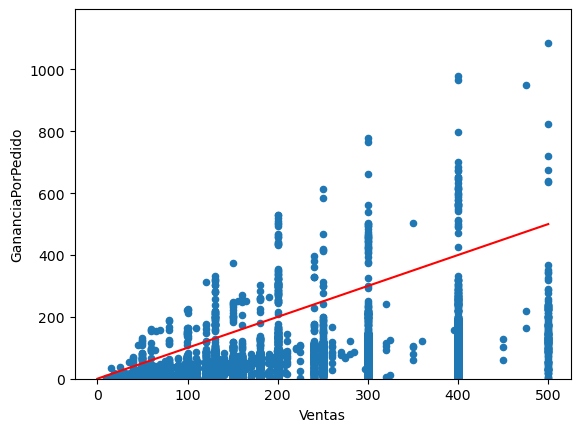

In [18]:
x = np.linspace(0, df_lineal['Ventas'].max(), 100) #establecemos el rango de valores de la variable x
y = w*x+b

#gráficamos:
df_lineal.plot.scatter(x='Ventas', y='GananciaPorPedido')
plt.plot(x,y,'-r')
plt.ylim(0,df_lineal['GananciaPorPedido'].max()*1.1)
plt.show()

# Podemos cambiar los valores de w y b para "jugar" con la recta, y ajustarla para obtener el menor error posible

Queremos obtener el mejor modelo, es decir el que presente menor error.
Para ello debemos calcular a cada modelo el error de predición y obtener el error cuadrático medio para luego compararlo con los demás modelos.

# Cálculo del Error de predicción
Nota: El error de predicción se obtiene de calcular la diferencia entre la predicción y el valor real, dicha diferencia puede ser un número negativo, por lo que tomaremos los cuadrados de dichas diferencias a fin de poder realizar comparaciones correctamente.

In [19]:
df_lineal['Predicciones'] = df_lineal['Ventas']*w+b #calculamos las predicciones

In [20]:
df_lineal['Diferencias'] = df_lineal['Predicciones']- df_lineal['GananciaPorPedido'] #Calculamos las diferencias
df_lineal['Cuadrados'] = df_lineal['Diferencias']**2 #Obtenemos los cuandrados

In [21]:
df_lineal.head()

,Pago,DiasEnvio(Real),DiasEnvio(Programado),BeneficioPorPedido,EstadoEntrega,RiesgoEntregaTardia,Categoria,PaisCliente,IDCliente,SegmentoCliente,...,EstadoPedido,IDProducto,CategoriaProducto,NombreProducto,PrecioProducto,FechaEnvio,ModoEnvio,Predicciones,Diferencias,Cuadrados
84,PAYMENT,4,2,23.469999,Late delivery,1,Women's Apparel,Puerto Rico,8541,Home Office,...,PENDING_PAYMENT,502,24,Nike Men's Dri-FIT Victory Golf Polo,50.000000,4/15/2017 15:49,Second Class,150.000000,126.530001,16009.841075
91,PAYMENT,4,2,32.860001,Late delivery,1,Shop By Sport,Puerto Rico,9272,Home Office,...,PENDING_PAYMENT,627,29,Under Armour Girls' Toddler Spine Surge Runni,39.990002,1/22/2017 19:37,Second Class,119.970001,87.110001,7588.152203
93,TRANSFER,6,4,55.090000,Late delivery,1,Shop By Sport,Puerto Rico,6398,Consumer,...,PENDING,627,29,Under Armour Girls' Toddler Spine Surge Runni,39.990002,2/13/2017 9:47,Standard Class,199.949997,144.859997,20984.418658
94,TRANSFER,4,4,68.589996,Shipping on time,0,Shop By Sport,Puerto Rico,4209,Consumer,...,PENDING,627,29,Under Armour Girls' Toddler Spine Surge Runni,39.990002,4/7/2015 19:08,Standard Class,199.949997,131.360001,17255.449747
95,TRANSFER,2,4,51.980000,Advance shipping,0,Women's Apparel,Puerto Rico,8917,Consumer,...,PENDING,502,24,Nike Men's Dri-FIT Victory Golf Polo,50.000000,4/15/2017 14:25,Standard Class,250.000000,198.020000,39211.920582


In [22]:
df_lineal['Cuadrados'].mean() #Calculamos el promedio o error cuadrático medio

28505.89064694621

Luego de realizar pruebas con diferentes valores de w (entre 0 y 2.5) y comparar los valores del ecm obtenido, podemos optimizar w calculando el mínimo promedio. Para ello realizamos una función cuadrática entre w y ecm y calculamos el vérticie de la parábola (o valor mínimo)

In [23]:
#grid del error:
w = np.linspace(0, 1, num=40) #trabajaremos con 20 valores diferentes dentro del rango
grid_error = pd.DataFrame(w, columns=['w'])
grid_error.head()

,w
0,0.000000
1,0.025641
2,0.051282
3,0.076923
4,0.102564


In [24]:
#Obtenemos los errores para cada valor:
def sum_error(w, df_espanol):
    b=0
    df_lineal['Predicciones'] = df_lineal['Ventas']*w+b
    df_lineal['Diferencias'] = df_lineal['Predicciones']-df_lineal['GananciaPorPedido']
    df_lineal['Cuadrados'] = df_lineal['Diferencias']**2
    return(df_lineal['Cuadrados'].mean())

In [25]:
#Agregamos los errores al nuevo df
grid_error['ecm']=grid_error['w'].apply(lambda x: sum_error(x, df_espanol=df_espanol))
grid_error.head()

,w,ecm
0,0.000000,9400.426271
1,0.025641,8591.726272
2,0.051282,7851.372784
3,0.076923,7179.365806
4,0.102564,6575.705339


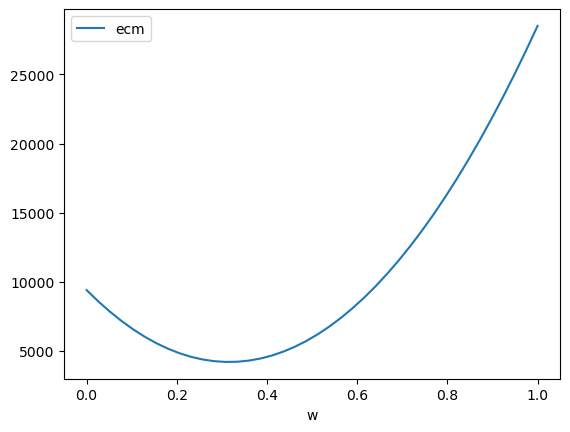

In [26]:
#graficamos:
grid_error.plot(x='w',y='ecm')
plt.show()

In [27]:
#obtenemos el menor w:
w = grid_error['w'].values
ecm = grid_error['ecm'].values
coeficientes = np.polyfit(w, ecm, 2) #armamos la ecuación de la función y obtenemos los coeficientes
a = coeficientes[0]
b = coeficientes[1]
c = coeficientes[2]

# calculamos el vértice y mostramos el valor de w
x_vertice = -b / (2 * a)
y_vertice = a * x_vertice**2 + b * x_vertice + c

print("El valor mínimo de w es:", (x_vertice))

El valor mínimo de w es: 0.31621416430592464


In [28]:
# Por lo que el mejor modelo es el que tiene como valores w=0.316 y b=0
# También podemos hacer el análisis con sklear:

In [29]:
# usando sklear para saber los valores optimos
from sklearn.linear_model import LinearRegression

# definiendo input y output
X_train = np.array(df_lineal['Ventas']).reshape((-1, 1))
Y_train = np.array(df_lineal['GananciaPorPedido'])

# creando modelo
model = LinearRegression(fit_intercept=False)
model.fit(X_train, Y_train)

# imprimiendo parametros
print(f"intercepto (b): {model.intercept_}")
print(f"pendiente (w): {model.coef_}")

intercepto (b): 0.0
pendiente (w): [0.31621416]


Interpretación de una Regresión Lineal entre Ventas y Ganancia por Pedido
¿Qué significa una regresión lineal entre ventas y ganancia por pedido?

Cuando realizamos una regresión lineal entre estas dos variables, estamos buscando establecer una relación matemática que nos permita predecir el valor de las ventas en función del valor de la ganancia por pedido, o viceversa. En otras palabras, estamos tratando de entender cómo cambia el nivel de ventas a medida que cambia la ganancia obtenida en cada pedido.

Interpretación de los Coeficientes:

Pendiente (Coeficiente de la variable independiente):

Indica la tasa de cambio en las ventas por cada unidad de aumento en la ganancia por pedido. Si la pendiente es positiva, significa que a medida que aumenta la ganancia por pedido, también aumentan las ventas (y viceversa si la pendiente es negativa).
Ejemplo: Si la pendiente es de 2, esto significa que por cada aumento de 1 unidad en la ganancia por pedido, las ventas aumentan en 2 unidades.
Intercepto:

Representa el valor de las ventas cuando la ganancia por pedido es cero. Sin embargo, este valor puede no tener un significado práctico en todos los casos, ya que puede ser que no tenga sentido tener una ganancia por pedido igual a cero.
¿Qué nos dice esta relación?

Causalidad vs. Correlación: Es importante recordar que la correlación no implica causalidad. Aunque encontremos una relación estadísticamente significativa entre las ventas y la ganancia por pedido, esto no necesariamente significa que un aumento en la ganancia por pedido cause un aumento en las ventas. Podría haber otras variables ocultas que influyen en ambas.
Predicción: La regresión lineal nos permite hacer predicciones sobre el valor de las ventas para diferentes niveles de ganancia por pedido. Sin embargo, es importante tener en cuenta que estas predicciones son estimaciones y pueden tener un margen de error.
Análisis de la relación: Podemos utilizar la regresión lineal para evaluar la fuerza y la dirección de la relación entre las dos variables. El coeficiente de determinación (R cuadrado) nos indica qué proporción de la variabilidad en las ventas puede ser explicada por la variabilidad en la ganancia por pedido.
Posibles Interpretaciones:

Relación positiva: Si la pendiente es positiva, podemos concluir que a medida que aumenta la ganancia por pedido, las ventas tienden a aumentar. Esto podría indicar que productos con mayor margen de ganancia son más populares o que una mayor ganancia por pedido permite invertir más en marketing y publicidad.
Relación negativa: Si la pendiente es negativa, significa que a medida que aumenta la ganancia por pedido, las ventas tienden a disminuir. Esto podría indicar, por ejemplo, que productos con mayor margen de ganancia son menos accesibles para los clientes y, por lo tanto, se venden menos.
No hay relación: Si la pendiente es cercana a cero, no hay una relación lineal significativa entre las dos variables.
Consideraciones Adicionales:

Otros factores: Es importante considerar que otros factores, como el precio, la calidad del producto, la competencia, las condiciones económicas, etc., pueden influir en las ventas y en la ganancia por pedido.
No linealidad: La relación entre las ventas y la ganancia por pedido puede no ser lineal. En estos casos, puede ser necesario utilizar modelos de regresión no lineales.
Datos atípicos: Los datos atípicos pueden influir significativamente en los resultados de la regresión lineal. Es importante identificar y analizar estos datos antes de realizar el análisis.
En resumen, la regresión lineal entre ventas y ganancia por pedido nos proporciona una herramienta útil para entender cómo estas dos variables están relacionadas y para hacer predicciones sobre el comportamiento futuro. Sin embargo, es importante interpretar los resultados con cautela y considerar el contexto en el que se obtuvieron los datos.

# Árbol de decisión
Un árbol de decisión es un modelo de aprendizaje automático que toma decisiones basadas en una serie de preguntas (nodos) para clasificar o predecir datos. Cada pregunta divide los datos en ramas, lo que lleva a decisiones finales (hojas) que representan las predicciones. Es una técnica de aprendizaje supervisado utilizada en clasificación y regresión. Exportamos el DataFrame ya trabajado anteriormente.

# Importar librerias
Pandas se utiliza para la manipulación y análisis de datos.
Matplotlib y Seaborn son bibliotecas para la visualización de datos.
Scikit-learn proporciona herramientas para dividir los datos, crear el modelo de árboles de decisión y evaluar su rendimiento.

In [30]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import learning_curve
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [ ]:
#Importación de dataset desde github
url = 'https://github.com/ISPC-PP1-2024/proyecto/blob/main/datos/DataCoSupplyChainDataset/DataCoSupplyChainDataset.csv'
df_1 = pd.read_csv(url)

In [31]:
# Se consulta la base de datos
#df_1=pd.read_csv('C:\\Users\\Usuario\\Desktop\\2024\\materias\\CDIA\\2semestre\\pp1-cdia23\\ejemplo suply chain\\DataCoSupplyChainDataset.csv\\para jupyter\\DataCoSupplyChainDataset.csv', encoding='latin1', sep=',',  low_memory=False)

In [32]:
# filtramos el set de datos original por país para abarcar solo argentina, brasil y mexico
#df = df_1[df_1['Order Country'].isin(['Argentina', 'Brasil', 'Mexico'])]

In [34]:
df_arbol.head()

,Pago,DiasEnvio(Real),DiasEnvio(Programado),BeneficioPorPedido,EstadoEntrega,RiesgoEntregaTardia,Categoria,PaisCliente,IDCliente,SegmentoCliente,...,EstadoPedido,IDProducto,CategoriaProducto,NombreProducto,PrecioProducto,FechaEnvio,ModoEnvio,Predicciones,Diferencias,Cuadrados
84,PAYMENT,4,2,23.469999,Late delivery,1,Women's Apparel,Puerto Rico,8541,Home Office,...,PENDING_PAYMENT,502,24,Nike Men's Dri-FIT Victory Golf Polo,50.000000,4/15/2017 15:49,Second Class,150.000000,126.530001,16009.841075
91,PAYMENT,4,2,32.860001,Late delivery,1,Shop By Sport,Puerto Rico,9272,Home Office,...,PENDING_PAYMENT,627,29,Under Armour Girls' Toddler Spine Surge Runni,39.990002,1/22/2017 19:37,Second Class,119.970001,87.110001,7588.152203
93,TRANSFER,6,4,55.090000,Late delivery,1,Shop By Sport,Puerto Rico,6398,Consumer,...,PENDING,627,29,Under Armour Girls' Toddler Spine Surge Runni,39.990002,2/13/2017 9:47,Standard Class,199.949997,144.859997,20984.418658
94,TRANSFER,4,4,68.589996,Shipping on time,0,Shop By Sport,Puerto Rico,4209,Consumer,...,PENDING,627,29,Under Armour Girls' Toddler Spine Surge Runni,39.990002,4/7/2015 19:08,Standard Class,199.949997,131.360001,17255.449747
95,TRANSFER,2,4,51.980000,Advance shipping,0,Women's Apparel,Puerto Rico,8917,Consumer,...,PENDING,502,24,Nike Men's Dri-FIT Victory Golf Polo,50.000000,4/15/2017 14:25,Standard Class,250.000000,198.020000,39211.920582


Carga y visualización de datos

In [35]:
# Ver información del dataset
df_arbol.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9918 entries, 84 to 179624
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Pago                     9918 non-null   object 
 1   DiasEnvio(Real)          9918 non-null   int64  
 2   DiasEnvio(Programado)    9918 non-null   int64  
 3   BeneficioPorPedido       9918 non-null   float64
 4   EstadoEntrega            9918 non-null   object 
 5   RiesgoEntregaTardia      9918 non-null   int64  
 6   Categoria                9918 non-null   object 
 7   PaisCliente              9918 non-null   object 
 8   IDCliente                9918 non-null   int64  
 9   SegmentoCliente          9918 non-null   object 
 10  PaisPedido               9918 non-null   object 
 11  FechaPedido              9918 non-null   object 
 12  IDPedido                 9918 non-null   int64  
 13  IDArticuloPedido         9918 non-null   int64  
 14  PrecioArticuloPedido     9

# Seleccionar Características Descriptivas y Variable Objetivo
Se definen las variables predictoras x, que incluyen las caracteristicas que impactan en el estado de entrega; y la variable objetivo y, que es el estado de entrega.

In [41]:
# Seleccionar características descriptivas y variable objetivo
X = df_arbol[['DiasEnvio(Real)', 'RiesgoEntregaTardia', 'Categoria', 'PaisCliente', 'ModoEnvio']]
y = df_arbol['EstadoEntrega']

# Preprocesamiento de datos
Conversión de tipos de datos

In [42]:
# Convertir las columnas a tipo de categoría. Esto permite optimizar el uso de memoria y mejora el rendimiento del modelo.
df_arbol['Categoria'] = df_arbol['Categoria'].astype('category')
df_arbol['PaisCliente'] = df_arbol['PaisCliente'].astype('category')
df_arbol['ModoEnvio'] = df_arbol['ModoEnvio'].astype('category')
df_arbol['EstadoEntrega'] = df_arbol['EstadoEntrega'].astype('category')

# Verificar el tipo de datos para asegurar que se haya realizado la conversión correctamente.
print(df.dtypes)

Pago                         object
DiasEnvio(Real)               int64
DiasEnvio(Programado)         int64
BeneficioPorPedido          float64
EstadoEntrega              category
RiesgoEntregaTardia           int64
Categoria                  category
PaisCliente                category
IDCliente                     int64
SegmentoCliente              object
PaisPedido                   object
FechaPedido                  object
IDPedido                      int64
IDArticuloPedido              int64
PrecioArticuloPedido        float64
CantidadArticulosPedido       int64
Ventas                      float64
TotalArticulosPedido        float64
GananciaPorPedido           float64
RegionPedido                 object
DestinoPedido                object
EstadoPedido                 object
IDProducto                    int64
CategoriaProducto             int64
NombreProducto               object
PrecioProducto              float64
FechaEnvio                   object
ModoEnvio                  c

# Codificación de Variables Categóricas

In [43]:
# Crear variables dummy (indicadoras) para las variables categóricas
X = pd.get_dummies(X, columns=['Categoria', 'PaisCliente', 'ModoEnvio'], drop_first=True)

# Manejo de Valores Nulos

In [44]:
# Verificar valores nulos
print(X.isnull().sum())

DiasEnvio(Real)                   0
RiesgoEntregaTardia               0
Categoria_As Seen on  TV!         0
Categoria_Baseball & Softball     0
Categoria_Boxing & MMA            0
Categoria_Camping & Hiking        0
Categoria_Cardio Equipment        0
Categoria_Cleats                  0
Categoria_Electronics             0
Categoria_Fishing                 0
Categoria_Fitness Accessories     0
Categoria_Girls' Apparel          0
Categoria_Golf Apparel            0
Categoria_Golf Bags & Carts       0
Categoria_Golf Balls              0
Categoria_Golf Gloves             0
Categoria_Golf Shoes              0
Categoria_Hockey                  0
Categoria_Hunting & Shooting      0
Categoria_Indoor/Outdoor Games    0
Categoria_Kids' Golf Clubs        0
Categoria_Lacrosse                0
Categoria_Men's Footwear          0
Categoria_Men's Golf Clubs        0
Categoria_Shop By Sport           0
Categoria_Soccer                  0
Categoria_Strength Training       0
Categoria_Tennis & Racquet  

# Dividir el Dataset
Se divide el dataset en un conjunto de entrenamiento, 80% y un conjunto de prueba, 20%.

In [45]:
# Dividir el dataset en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Inicialización y entrenamiento del modelo

In [46]:
# Inicializar el modelo
modelo = DecisionTreeClassifier(criterion='entropy')

# Entrenar el modelo
modelo.fit(X_train, y_train)


DecisionTreeClassifier(criterion='entropy')

# Evaluación del modelo

In [47]:
# Predecir en el conjunto de prueba
y_pred = modelo.predict(X_test)

# Evaluar precisión
precision = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {precision}')

# Reporte de clasificación
print(classification_report(y_test, y_pred))

Precisión del modelo: 0.9813508064516129
                   precision    recall  f1-score   support

 Advance shipping       0.97      0.99      0.98       477
    Late delivery       1.00      1.00      1.00      1094
Shipping canceled       0.91      0.62      0.74        84
 Shipping on time       0.96      1.00      0.98       329

         accuracy                           0.98      1984
        macro avg       0.96      0.90      0.92      1984
     weighted avg       0.98      0.98      0.98      1984



# Resultados del modelo
Precisión del modelo: 98.13%, lo que indica que el modelo es muy efectivo en la clasificación. El reporte de clasificación muestra que el modelo funciona bien para la mayoría de las clases, pero tiene un menor desempeño para la clase "Shipping canceled" debido a que el recall es más bajo (0.62).

# Mejora del modelo
# Ajuste de hiperparámetros

In [48]:
# Definición del modelo para búsqueda de hiperpárametros.
dt_model = DecisionTreeClassifier(random_state=42)

# Definición de los parámetros a probar
param_grid = {
    'criterion': ['entropy', 'gini'],  # Criterio para dividir
    'max_depth': [None, 5, 10, 15, 20],  # Profundidad máxima
    'min_samples_split': [2, 5, 10]  # Mínimo de muestras para dividir
}

# Búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)

# Entrenamiento
grid_search.fit(X_train, y_train)

# Mejores hiperparámetros
best_params = grid_search.best_params_
print("Mejores Hiperparámetros:", best_params)


Mejores Hiperparámetros: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}


# Entrenamiento con los mejores hiperparámetros

In [49]:
# Entrenando el modelo con los mejores hiperparámetros
best_dt_model = DecisionTreeClassifier(**best_params, random_state=42)
best_dt_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)

# Evaluación del modelo optimizado

In [50]:
# Predicciones
y_pred = best_dt_model.predict(X_test)

# Evaluación
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo mejorado:", accuracy)

# Reporte de clasificación
report = classification_report(y_test, y_pred)
print("Reporte de Clasificación:\n", report)


Precisión del modelo mejorado: 0.9838709677419355
Reporte de Clasificación:
                    precision    recall  f1-score   support

 Advance shipping       0.97      1.00      0.98       477
    Late delivery       1.00      1.00      1.00      1094
Shipping canceled       1.00      0.62      0.76        84
 Shipping on time       0.96      1.00      0.98       329

         accuracy                           0.98      1984
        macro avg       0.98      0.90      0.93      1984
     weighted avg       0.98      0.98      0.98      1984



# Resultados del modelo optimizado
El modelo optimizado de árboles de decisión ha logrado una precisión del 98.39%, representando una leve mejora en comparación con el modelo inicial.

Las clases "Advance shipping", "Late delivery", y "Shipping on time" continúan mostrando un excelente rendimiento con una precisión y recall cercanas al 100%, lo que refuerza la efectividad del modelo en la predicción de estas clases. La clase "Shipping canceled", aunque mejoró su precisión al 100%, sigue teniendo dificultades con el recall, alcanzando solo el 62%. Esto significa que, si bien el modelo es efectivo para identificar correctamente las cancelaciones cuando las predice, aún falla en detectar todos los casos de cancelaciones. La optimización del modelo ha consolidado su precisión general, haciéndolo adecuado para aplicaciones donde se requiera predecir con alta confianza el estado de entrega de los pedidos. Sin embargo, sigue existiendo un área de mejora en la identificación de las cancelaciones. A pesar de esto, los resultados obtenidos proporcionan un excelente punto de partida para implementar soluciones de optimización logística, lo que podría ayudar a la empresa a prevenir demoras y mejorar la satisfacción del cliente.

# Análisis de la importancia de características
Ayuda a identificar que variables son más influyentes en las predicciones del modelo.

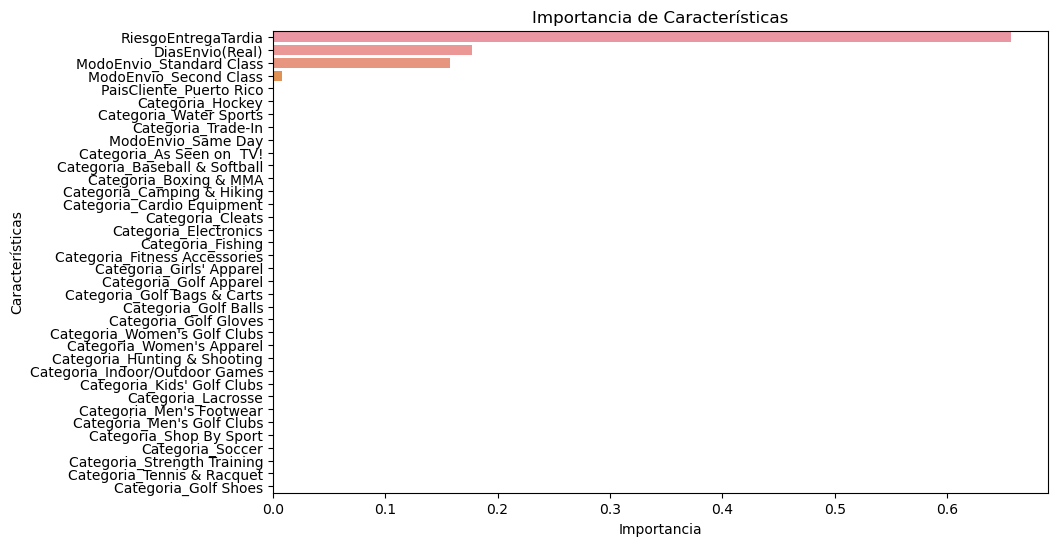

In [51]:
# Importancia de características
importances = best_dt_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Visualización
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.title('Importancia de Características')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

# Validación cruzada
Se realiza validación cruzada en el modelo optimizado y se calcula la precisión promedio, lo que ayuda a evaluar la estabilidad del modelo en diferentes subconjuntos de datos.

In [52]:
# Validación cruzada
cv_scores = cross_val_score(best_dt_model, X_train, y_train, cv=5)
print("Precisión promedio en Validación Cruzada:", cv_scores.mean())

Precisión promedio en Validación Cruzada: 0.9779425518339027


In [53]:
# Filtrando los errores
errors = X_test[y_pred != y_test]
print(errors)


        DiasEnvio(Real)  RiesgoEntregaTardia  Categoria_As Seen on  TV!  \
177934                3                    0                      False   
56225                 3                    0                      False   
51218                 2                    0                      False   
159540                2                    0                      False   
159530                3                    0                      False   
169783                2                    0                      False   
138117                4                    0                      False   
4962                  3                    0                      False   
113325                4                    0                      False   
114765                3                    0                      False   
50790                 4                    0                      False   
5683                  4                    0                      False   
1012                  4  

# Matriz de confusión

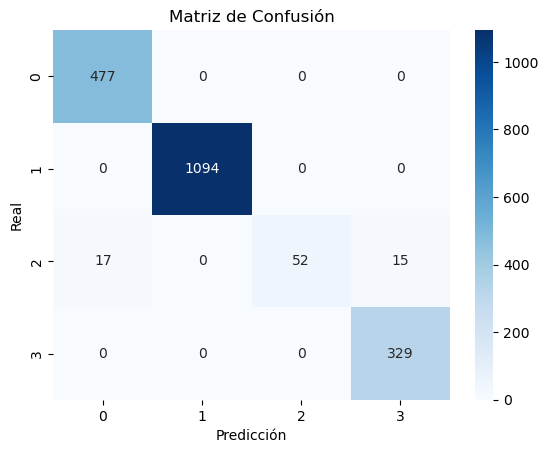

                   precision    recall  f1-score   support

 Advance shipping       0.97      1.00      0.98       477
    Late delivery       1.00      1.00      1.00      1094
Shipping canceled       1.00      0.62      0.76        84
 Shipping on time       0.96      1.00      0.98       329

         accuracy                           0.98      1984
        macro avg       0.98      0.90      0.93      1984
     weighted avg       0.98      0.98      0.98      1984



In [54]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Reporte de clasificación
print(classification_report(y_test, y_pred))

# Curvas de aprendizaje

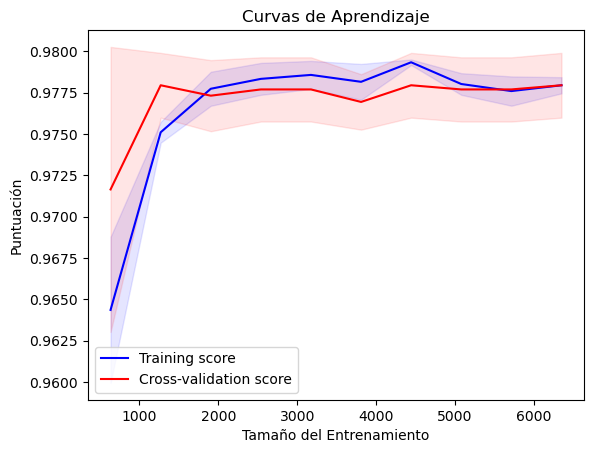

In [55]:
# Evaluación del rendimiento del modelo en función del tamaño del conjunto de entrenamiento.
train_sizes, train_scores, test_scores = learning_curve(best_dt_model, X_train, y_train, 
                                                          cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Media y desviación estándar de los puntajes
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Gráfico de las curvas de aprendizaje
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.plot(train_sizes, test_mean, label='Cross-validation score', color='red')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='red', alpha=0.1)
plt.title('Curvas de Aprendizaje')
plt.xlabel('Tamaño del Entrenamiento')
plt.ylabel('Puntuación')
plt.legend()
plt.show()


# REGRESION LOGISTICA

In [ ]:
#Importación de dataset desde github
url = 'https://github.com/ISPC-PP1-2024/proyecto/blob/main/datos/DataCoSupplyChainDataset/DataCoSupplyChainDataset.csv'
df_1 = pd.read_csv(url)


In [66]:
# Se consulta la base de datos
df_logistica=pd.read_csv('C:\\Users\\Usuario\\Desktop\\2024\\materias\\CDIA\\2semestre\\pp1-cdia23\\ejemplo suply chain\\DataCoSupplyChainDataset.csv\\para jupyter\\DataCoSupplyChainDataset.csv', encoding='latin1', sep=',',  low_memory=False)

In [67]:
df_logistica = df_logistica[df_logistica['Order Country'].isin(['Argentina', 'Brasil', 'Mexico'])]

In [71]:
# Cantidad de valores nulos por columna
missing_data = df_logistica.isna().sum()
print(missing_data[missing_data > 0])

Order Zipcode          9918
Product Description    9918
dtype: int64


In [73]:
#ELIMINAMOS FILAS DEL DATAFRAME QUE NO USAMOS.
columnas_a_eliminar = ['Category Id','Customer Email','Customer Fname','Customer Lname',
'Customer Password','Customer State','Customer Street','Customer Zipcode','Department Id','Department Name','Latitude',
'Longitude','Market','Order City','Order Customer Id','Order Item Cardprod Id','Order Item Discount', 'Order Item Discount Rate',
'Order Item Profit Ratio','Product Image','Product Description','Order Zipcode','Product Status']


In [74]:
df_logistica = df_logistica.drop(columns=columnas_a_eliminar, axis=1)
df_logistica.columns

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Id', 'Customer Segment', 'Order Country',
       'order date (DateOrders)', 'Order Id', 'Order Item Id',
       'Order Item Product Price', 'Order Item Quantity', 'Sales',
       'Order Item Total', 'Order Profit Per Order', 'Order Region',
       'Order State', 'Order Status', 'Product Card Id', 'Product Category Id',
       'Product Name', 'Product Price', 'shipping date (DateOrders)',
       'Shipping Mode'],
      dtype='object')

In [75]:
#renombro la columna porque tiene espacios
df_logistica.rename(columns={'Category Name':'Categoria',
                           'Type':'Pago'
                           ,'Days for shipping (real)':'DiasEnvio(Real)'
                           , 'Days for shipment (scheduled)':'DiasEnvio(Programado)'
                           , 'Benefit per order':'BeneficioPorPedido'
                           , 'Delivery Status':'EstadoEntrega'
                           , 'Late_delivery_risk':'RiesgoEntregaTardia'
                           , 'Category Name':'Categoria'
                           , 'Customer Country':'PaisCliente'
                           , 'Customer Id':'IDCliente'
                           , 'Customer Segment':'SegmentoCliente'
                           , 'Order Country':'PaisPedido'
                           , 'order date (DateOrders)':'FechaPedido'
                           , 'Order Id':'IDPedido'
                           , 'Order Item Id':'IDArticuloPedido'
                           , 'Order Item Product Price':'PrecioArticuloPedido'
                           , 'Order Item Quantity':'CantidadArticulosPedido'
                           , 'Sales':'Ventas'
                           , 'Order Item Total':'TotalArticulosPedido'
                           , 'Order Profit Per Order':'GananciaPorPedido'
                           , 'Order Region':'RegionPedido'
                           , 'Order State':'DestinoPedido'
                           , 'Order Status':'EstadoPedido'
                           , 'Product Card Id':'IDProducto'
                           , 'Product Category Id':'CategoriaProducto'
                           , 'Product Name':'NombreProducto'
                           , 'Product Price':'PrecioProducto'
                           , 'shipping date (DateOrders)':'FechaEnvio'
                           , 'Shipping Mode':'ModoEnvio' 
                           , 'Customer City':'CiudadCliente'
                           , 'Sales per customer' : 'VentasPorCliente'
                          
                          },inplace=True)


In [76]:
# Columnas traducidas
df_logistica.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9918 entries, 84 to 179624
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Pago                     9918 non-null   object 
 1   DiasEnvio(Real)          9918 non-null   int64  
 2   DiasEnvio(Programado)    9918 non-null   int64  
 3   BeneficioPorPedido       9918 non-null   float64
 4   VentasPorCliente         9918 non-null   float64
 5   EstadoEntrega            9918 non-null   object 
 6   RiesgoEntregaTardia      9918 non-null   int64  
 7   Categoria                9918 non-null   object 
 8   CiudadCliente            9918 non-null   object 
 9   PaisCliente              9918 non-null   object 
 10  IDCliente                9918 non-null   int64  
 11  SegmentoCliente          9918 non-null   object 
 12  PaisPedido               9918 non-null   object 
 13  FechaPedido              9918 non-null   object 
 14  IDPedido                 9

In [77]:
#tamaño del nuevo dataframe
df_logistica.shape

(9918, 30)

In [78]:
df_logistica.nunique()

Pago                          4
DiasEnvio(Real)               7
DiasEnvio(Programado)         4
BeneficioPorPedido         5468
VentasPorCliente           1076
EstadoEntrega                 4
RiesgoEntregaTardia           2
Categoria                    31
CiudadCliente               492
PaisCliente                   2
IDCliente                  2910
SegmentoCliente               3
PaisPedido                    2
FechaPedido                3292
IDPedido                   3292
IDArticuloPedido           9918
PrecioArticuloPedido         50
CantidadArticulosPedido       5
Ventas                      162
TotalArticulosPedido       1076
GananciaPorPedido          5468
RegionPedido                  1
DestinoPedido                47
EstadoPedido                  9
IDProducto                   87
CategoriaProducto            32
NombreProducto               87
PrecioProducto               50
FechaEnvio                 3269
ModoEnvio                     4
dtype: int64

## 2. Análisis exploratorio con gráficos

Un análisis rápido de las variables

In [79]:
#Tiene missings, minimos, maximos, medias, desviación estandar
df_logistica.describe()

,DiasEnvio(Real),DiasEnvio(Programado),BeneficioPorPedido,VentasPorCliente,RiesgoEntregaTardia,IDCliente,IDPedido,IDArticuloPedido,PrecioArticuloPedido,CantidadArticulosPedido,Ventas,TotalArticulosPedido,GananciaPorPedido,IDProducto,CategoriaProducto,PrecioProducto
count,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000
mean,3.527022,2.977011,22.737589,178.833487,0.537407,6315.521879,31009.398064,77548.855818,133.613664,2.178463,198.937902,178.833487,22.737589,663.466223,30.254386,133.613664
std,1.624354,1.356149,94.256693,101.225074,0.498624,3564.426209,25798.434647,64536.644796,116.668712,1.467132,111.366436,101.225074,94.256693,309.187722,13.649110,116.668712
min,0.000000,0.000000,-1086.390015,9.890000,0.000000,3.000000,7.000000,14.000000,9.990000,1.000000,9.990000,9.890000,-1086.390015,19.000000,2.000000,9.990000
25%,2.000000,2.000000,8.100000,104.370003,0.000000,3318.250000,5655.250000,14098.250000,50.000000,1.000000,119.980003,104.370003,8.100000,403.000000,18.000000,50.000000
50%,3.000000,4.000000,32.115000,163.990005,1.000000,6224.000000,10269.000000,25703.500000,59.990002,1.000000,199.919998,163.990005,32.115000,627.000000,29.000000,59.990002
75%,5.000000,4.000000,63.677500,245.000000,1.000000,9371.000000,56892.000000,142302.750000,199.990005,3.000000,299.950012,245.000000,63.677500,1004.000000,45.000000,199.990005
max,6.000000,4.000000,249.979996,499.950012,1.000000,12434.000000,61584.000000,153996.000000,399.980011,5.000000,500.000000,499.950012,249.979996,1073.000000,48.000000,399.980011


Algo importante a notar aquí es que todas las variables tienen un millón en el conteo, eso indica que ninguna variable tiene registros vacios
Para las tres primeras variables que son continuas se deja al lector la interpretación de la media, desviasión estandar y demas métricas contenidas

In [80]:
# 1. Examinar la columna antes de la conversión
print("Primeros 5 valores de 'PrecioProducto' antes de la conversión:")
print(df_logistica['PrecioProducto'].head())
print("\nTipo de dato actual:", df_logistica['PrecioProducto'].dtype)

# 2. Función para limpiar y convertir la columna
def clean_and_convert(x):
    if isinstance(x, str):
        return pd.to_numeric(x.replace('$', '').replace(',', ''), errors='coerce')
    return x

# 3. Aplicar la función de conversión
df_logistica['PrecioProducto'] = df_logistica['PrecioProducto'].apply(clean_and_convert)

# 4. Verificar la conversión
print("\nPrimeros 5 valores de 'PrecioProducto' después de la conversión:")
print(df_logistica['PrecioProducto'].head())
print("\nNuevo tipo de dato:", df_logistica['PrecioProducto'].dtype)

# 5. Verificar valores nulos o inválidos
nulos = df_logistica['PrecioProducto'].isnull().sum()
print(f"\nNúmero de valores nulos: {nulos}")

# 6. Estadísticas descriptivas
print("\nEstadísticas descriptivas de 'PrecioProducto':")
print(df_logistica['PrecioProducto'].describe())

# 7. Identificar valores atípicos o sospechosos (opcional)
Q1 = df_logistica['PrecioProducto'].quantile(0.25)
Q3 = df_logistica['PrecioProducto'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

atipicos = df_logistica[(df_logistica['PrecioProducto'] < lower_bound) | (df_logistica['PrecioProducto'] > upper_bound)]
print(f"\nNúmero de valores atípicos: {len(atipicos)}")

# 8. Mostrar algunos valores atípicos si existen
if len(atipicos) > 0:
    print("\nAlgunos valores atípicos:")
    print(atipicos['PrecioProducto'].head())

Primeros 5 valores de 'PrecioProducto' antes de la conversión:
84    50.000000
91    39.990002
93    39.990002
94    39.990002
95    50.000000
Name: PrecioProducto, dtype: float64

Tipo de dato actual: float64

Primeros 5 valores de 'PrecioProducto' después de la conversión:
84    50.000000
91    39.990002
93    39.990002
94    39.990002
95    50.000000
Name: PrecioProducto, dtype: float64

Nuevo tipo de dato: float64

Número de valores nulos: 0

Estadísticas descriptivas de 'PrecioProducto':
count    9918.000000
mean      133.613664
std       116.668712
min         9.990000
25%        50.000000
50%        59.990002
75%       199.990005
max       399.980011
Name: PrecioProducto, dtype: float64

Número de valores atípicos: 0


In [81]:
# 1. Examinar la columna antes de la conversión
print("Primeros 5 valores de 'Product Price' antes de la conversión:")
print(df_logistica['GananciaPorPedido'].head())
print("\nTipo de dato actual:", df_logistica['GananciaPorPedido'].dtype)

# 2. Función para limpiar y convertir la columna
def clean_and_convert(x):
    if isinstance(x, str):
        return pd.to_numeric(x.replace('$', '').replace(',', ''), errors='coerce')
    return x

# 3. Aplicar la función de conversión
df_logistica['GananciaPorPedido'] = df_logistica['GananciaPorPedido'].apply(clean_and_convert)

# 4. Verificar la conversión
print("\nPrimeros 5 valores de 'Product Price' después de la conversión:")
print(df_logistica['GananciaPorPedido'].head())
print("\nNuevo tipo de dato:", df_logistica['GananciaPorPedido'].dtype)

# 5. Verificar valores nulos o inválidos
nulos = df_logistica['GananciaPorPedido'].isnull().sum()
print(f"\nNúmero de valores nulos: {nulos}")

# 6. Estadísticas descriptivas
print("\nEstadísticas descriptivas de 'Product Price':")
print(df_logistica['GananciaPorPedido'].describe())

# 7. Identificar valores atípicos o sospechosos (opcional)
Q1 = df_logistica['GananciaPorPedido'].quantile(0.25)
Q3 = df_logistica['GananciaPorPedido'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

atipicos = df_logistica[(df_logistica['GananciaPorPedido'] < lower_bound) | (df_logistica['GananciaPorPedido'] > upper_bound)]
print(f"\nNúmero de valores atípicos: {len(atipicos)}")

# 8. Mostrar algunos valores atípicos si existen
if len(atipicos) > 0:
    print("\nAlgunos valores atípicos:")
    print(atipicos['GananciaPorPedido'].head())

Primeros 5 valores de 'Product Price' antes de la conversión:
84    23.469999
91    32.860001
93    55.090000
94    68.589996
95    51.980000
Name: GananciaPorPedido, dtype: float64

Tipo de dato actual: float64

Primeros 5 valores de 'Product Price' después de la conversión:
84    23.469999
91    32.860001
93    55.090000
94    68.589996
95    51.980000
Name: GananciaPorPedido, dtype: float64

Nuevo tipo de dato: float64

Número de valores nulos: 0

Estadísticas descriptivas de 'Product Price':
count    9918.000000
mean       22.737589
std        94.256693
min     -1086.390015
25%         8.100000
50%        32.115000
75%        63.677500
max       249.979996
Name: GananciaPorPedido, dtype: float64

Número de valores atípicos: 1026

Algunos valores atípicos:
671    -245.940002
1005   -107.870003
1637   -154.679993
1812    161.259995
3030    -85.500000
Name: GananciaPorPedido, dtype: float64


# Una regresión lógistica requiere de dos tipos de variables.
1.Variable objetivo: también llamada dependiente, en este caso la variable objetivo es fraud
<br>
2.Variables independientes: en este caso puede ser una o todas las demas dependiendo de la correlación que tengan con la variable objetivo
<br>Dicho esto, todo el análisis exploratorio debe girar en torno a la correlación que exista entre las variables independientes y la dependiente (fraud)
<br>Pero, cuantas transacciones, del millón que contiene la base, fueron marcadas como fraude

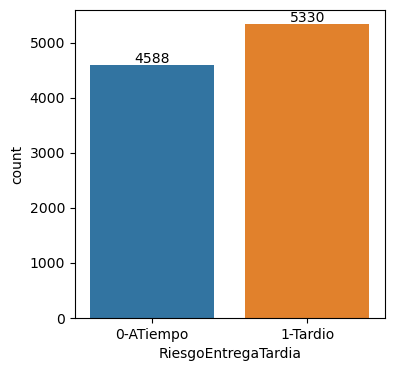

In [82]:
plt.figure(figsize=(4,4))

ax1=sb.countplot(x="RiesgoEntregaTardia", data=df_logistica)
for label in ax1.containers:
    ax1.bar_label(label)
    ax1.set_xticklabels(['0-ATiempo','1-Tardio'])
plt.show()

** Aproximadamente el 45,17 % de las observaciones fueron marcadas como entrega a tiempo (riesgo) Aproximadamente el 54.83 % de las observaciones fueron marcadas como entrega tardia (riesgo)

** Ahora se graficarán las variables continuas considerando la variable objetivo
Para hacer comparables las variables continuas se obtiene el logaritmo base 10, esto también ayuda a tener más cercanos los datos

In [83]:
df_logistica.columns

Index(['Pago', 'DiasEnvio(Real)', 'DiasEnvio(Programado)',
       'BeneficioPorPedido', 'VentasPorCliente', 'EstadoEntrega',
       'RiesgoEntregaTardia', 'Categoria', 'CiudadCliente', 'PaisCliente',
       'IDCliente', 'SegmentoCliente', 'PaisPedido', 'FechaPedido', 'IDPedido',
       'IDArticuloPedido', 'PrecioArticuloPedido', 'CantidadArticulosPedido',
       'Ventas', 'TotalArticulosPedido', 'GananciaPorPedido', 'RegionPedido',
       'DestinoPedido', 'EstadoPedido', 'IDProducto', 'CategoriaProducto',
       'NombreProducto', 'PrecioProducto', 'FechaEnvio', 'ModoEnvio'],
      dtype='object')

C:\Users\Usuario\anaconda3\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Usuario\anaconda3\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Usuario\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Usuario\anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Usuario\anaconda3\lib\site-packages\seaborn\_oldc

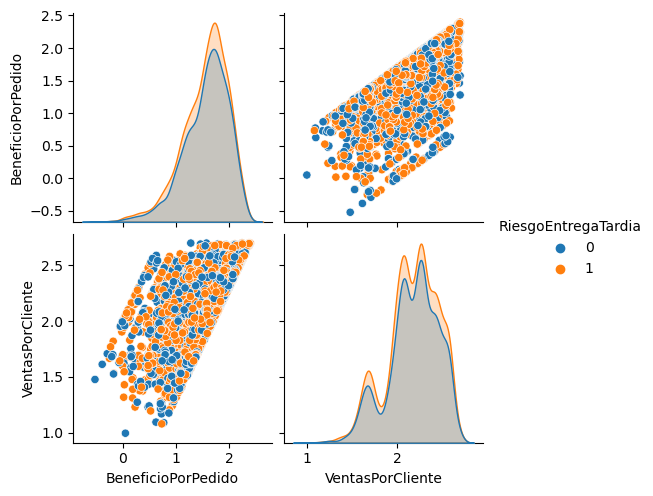

In [84]:
df_logistica['BeneficioPorPedido'] = np.log10(df_logistica['BeneficioPorPedido'])
df_logistica['VentasPorCliente'] = np.log10(df_logistica['VentasPorCliente'])
sb.pairplot(data=df_logistica[['BeneficioPorPedido','VentasPorCliente','RiesgoEntregaTardia']], hue = 'RiesgoEntregaTardia')
plt.show()

In [85]:
from sklearn.preprocessing import LabelEncoder

In [88]:
df_logistica['PaisCliente'] =df_logistica['PaisCliente'] 
label_encoder_PaisCliente=LabelEncoder()

df_logistica['PaisCliente'] = label_encoder_PaisCliente.fit_transform(df_logistica['PaisCliente'])

*** se aprecia que a lo largo de los pedidos no hay variacion significativa entre el porcentaje de riesgo positivo y negativo
***la cantidad de pedidos es mayor en la segunda mitad de,,,pero se comporta igual

In [89]:
df_logistica['PaisCliente']

84        1
91        1
93        1
94        1
95        1
         ..
179597    1
179613    1
179618    1
179623    1
179624    1
Name: PaisCliente, Length: 9918, dtype: int32

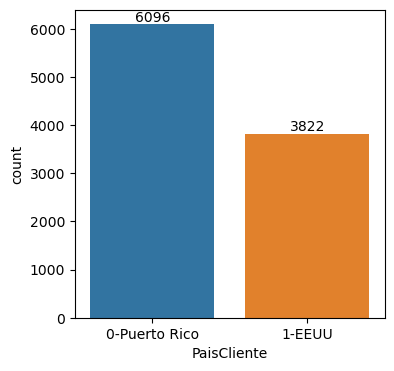

In [90]:
plt.figure(figsize=(4,4))

ax1=sb.countplot(x="PaisCliente", data=df_logistica)
for label in ax1.containers:
    ax1.bar_label(label)
    ax1.set_xticklabels(['0-Puerto Rico','1-EEUU'])
plt.show()

Ahora veamos la correlación que existe con las variables binarias

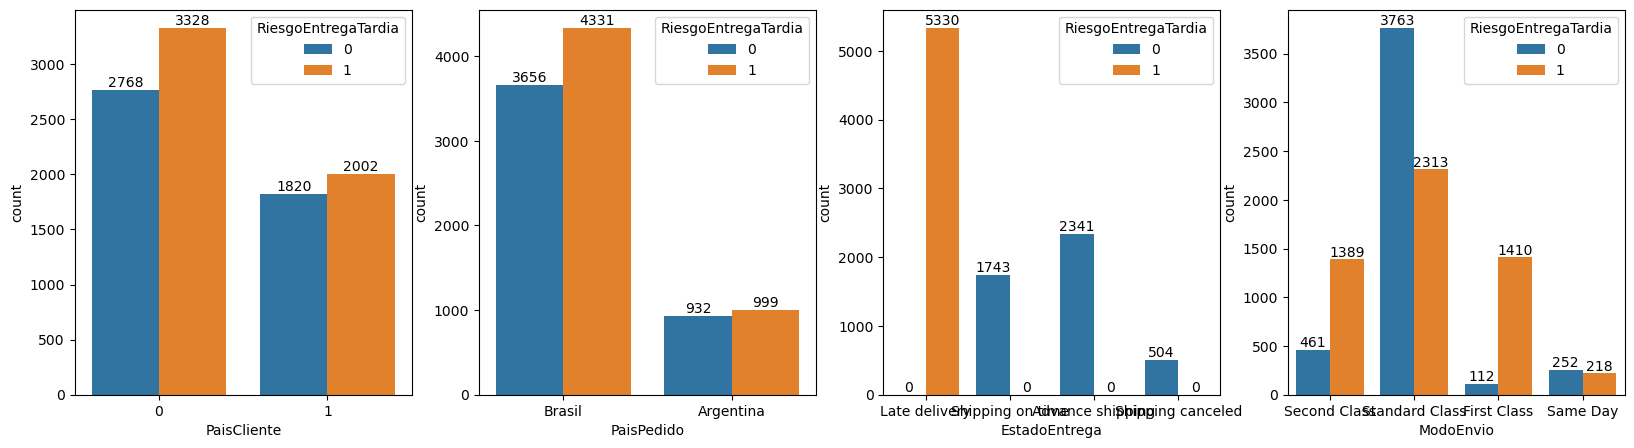

<Figure size 300x400 with 0 Axes>

<Figure size 300x400 with 0 Axes>

<Figure size 300x400 with 0 Axes>

<Figure size 300x400 with 0 Axes>

In [92]:
variables_binarias = ['PaisCliente', 'PaisPedido','EstadoEntrega','ModoEnvio']
fig,ax = plt.subplots(1,4,figsize=(20,5))

for i,col in enumerate(variables_binarias):
    plt.figure(figsize=(3,4))
    ax[i]=sb.countplot(x=col, data=df_logistica, hue="RiesgoEntregaTardia", ax=ax[i])
    for label in ax[i].containers:
        ax[i].bar_label(label)

##detalle de las graficas,,,,,,,

### Para terminar el análisis exploratorio se hace un mapa de calor que indica las correlaciones, esto puede fortalecer los primeros hallazgos o refutarlos

In [93]:
data=df_logistica.copy()
data['RIESGO_TARDIO'] = np.where(data['EstadoPedido'] == 'RIESGO_TARDIO', 1, 0)

In [94]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
def Labelencoder_feature(x):
    le=LabelEncoder()
    x=le.fit_transform(x)
    return x

In [95]:
features=data.drop(columns=['RIESGO_TARDIO','EstadoPedido' ])
target=data['RIESGO_TARDIO']

In [96]:
features.isnull().sum()

Pago                          0
DiasEnvio(Real)               0
DiasEnvio(Programado)         0
BeneficioPorPedido         1815
VentasPorCliente              0
EstadoEntrega                 0
RiesgoEntregaTardia           0
Categoria                     0
CiudadCliente                 0
PaisCliente                   0
IDCliente                     0
SegmentoCliente               0
PaisPedido                    0
FechaPedido                   0
IDPedido                      0
IDArticuloPedido              0
PrecioArticuloPedido          0
CantidadArticulosPedido       0
Ventas                        0
TotalArticulosPedido          0
GananciaPorPedido             0
RegionPedido                  0
DestinoPedido                 0
IDProducto                    0
CategoriaProducto             0
NombreProducto                0
PrecioProducto                0
FechaEnvio                    0
ModoEnvio                     0
dtype: int64

In [97]:
#se consideran los valores NaN , tratarlo para utilizar labelEncoder
features=features.apply(Labelencoder_feature)
features.head()

,Pago,DiasEnvio(Real),DiasEnvio(Programado),BeneficioPorPedido,VentasPorCliente,EstadoEntrega,RiesgoEntregaTardia,Categoria,CiudadCliente,PaisCliente,...,TotalArticulosPedido,GananciaPorPedido,RegionPedido,DestinoPedido,IDProducto,CategoriaProducto,NombreProducto,PrecioProducto,FechaEnvio,ModoEnvio
84,2,4,2,1121,656,1,1,29,57,1,...,656,2693,0,4,28,13,41,18,1655,2
91,2,4,2,1506,457,1,1,23,57,1,...,457,3078,0,45,35,15,72,14,122,2
93,3,6,3,2342,810,1,1,23,57,1,...,810,3914,0,5,35,15,72,14,440,3
94,3,4,3,2750,803,3,0,23,57,1,...,803,4322,0,45,35,15,72,14,1999,3
95,3,2,3,2239,918,0,0,29,57,1,...,918,3811,0,45,28,13,41,18,1653,3


In [98]:
#borrar caracteristicas con alta correlacion con otras caracteristicas para evitar multicolinealidad
data1=pd.concat([features,target],axis=1)

In [99]:
#deleting features which high-correlated with other features to avoid multicollinarity

corr = data1.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.8:
            if columns[j]:
                columns[j] = False
selected_columns = data1.columns[columns]
selected_columns

Index(['Pago', 'DiasEnvio(Real)', 'DiasEnvio(Programado)',
       'BeneficioPorPedido', 'VentasPorCliente', 'EstadoEntrega',
       'RiesgoEntregaTardia', 'Categoria', 'CiudadCliente', 'PaisCliente',
       'IDCliente', 'SegmentoCliente', 'PaisPedido', 'FechaPedido', 'IDPedido',
       'PrecioArticuloPedido', 'CantidadArticulosPedido', 'GananciaPorPedido',
       'RegionPedido', 'DestinoPedido', 'IDProducto', 'NombreProducto',
       'RIESGO_TARDIO'],
      dtype='object')

<Axes: >

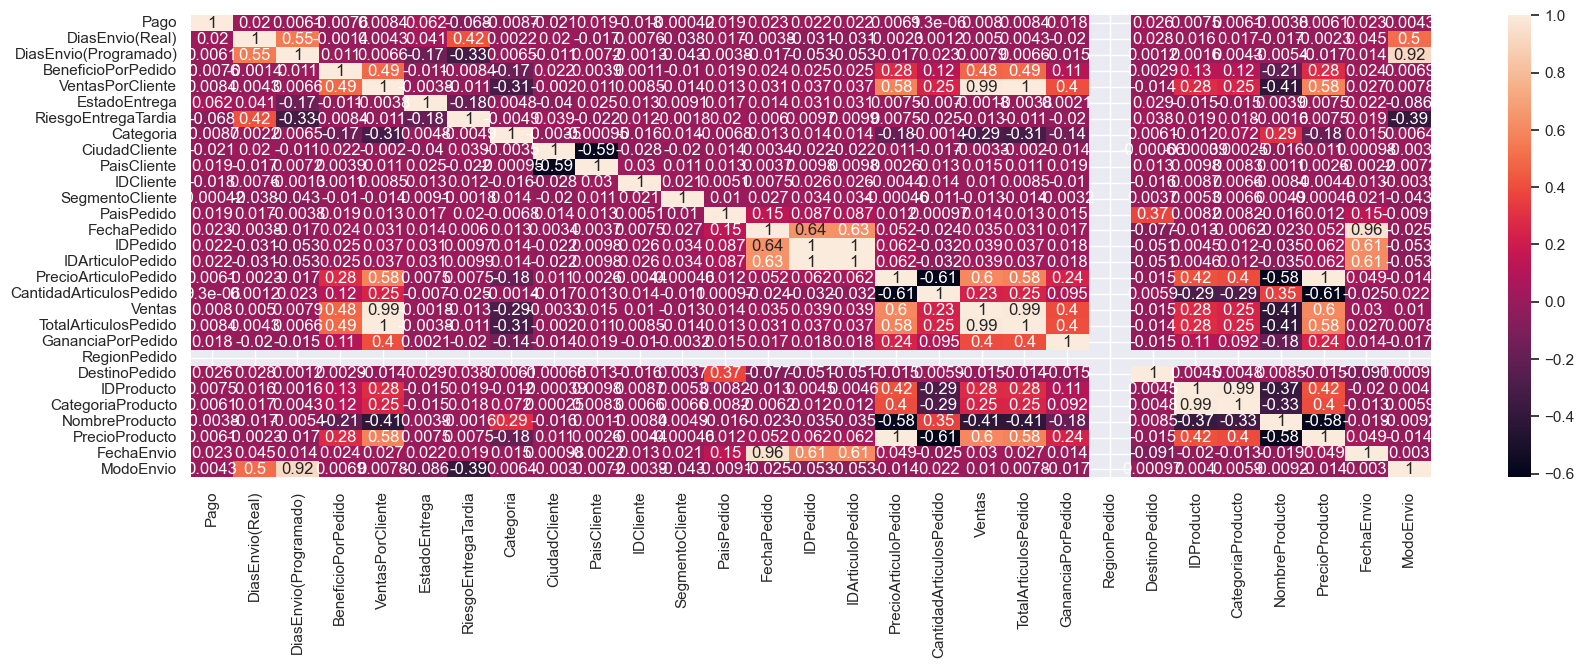

In [100]:
sb.set(rc = {"figure.figsize":(20, 6)}) #graph size
corr = features.corr()
sb.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True, cmap = "rocket") #viridis, rocket, rocket_r, hot entre otras son las mejores paletas de colores para este caso

In [150]:
features.shape

(9918, 29)

# Con este mapa de calor se nota que:
<br> La variable que tiene la mayor correlación
<br> La variables con buena correlación
<br> La variable con correlacion negativa
# 3. Desarrollo y validación de la Regresión Logística
hay valores NAN, hay que limpiar primero.-........luego esto se hace arriba al principio con el tratamiento

In [101]:
columnas_a_verificar=['Pago', 'DiasEnvio(Real)', 'DiasEnvio(Programado)',
       'BeneficioPorPedido', 'VentasPorCliente', 'EstadoEntrega',
       'RiesgoEntregaTardia', 'Categoria', 'CiudadCliente', 'PaisCliente',
       'IDCliente', 'SegmentoCliente', 'PaisPedido', 'FechaPedido', 'IDPedido',
       'PrecioArticuloPedido', 'CantidadArticulosPedido', 'Ventas',
       'TotalArticulosPedido', 'GananciaPorPedido', 'RegionPedido',
       'DestinoPedido', 'IDProducto', 'NombreProducto', 'PrecioProducto']
# Eliminar filas con al menos un NaN en las columnas especificadas
features = features.dropna(subset=columnas_a_verificar)

In [102]:
# verificar filas duplicadas
duplicados=features[features.duplicated()]
if duplicados.empty:
    print("No hay filas duplicadas en el DataFrame.")
else:
    print("Las siguientes filas están duplicadas:")
    print(duplicados)

No hay filas duplicadas en el DataFrame.


In [103]:
# Suponiendo que tu DataFrame se llama 'df'
columnas_a_verificar = ['Pago', 'DiasEnvio(Real)', 'DiasEnvio(Programado)',
       'BeneficioPorPedido', 'VentasPorCliente', 'EstadoEntrega',
       'RiesgoEntregaTardia', 'Categoria', 'CiudadCliente', 'PaisCliente',
       'IDCliente', 'SegmentoCliente', 'PaisPedido', 'FechaPedido', 'IDPedido',
       'PrecioArticuloPedido', 'CantidadArticulosPedido', 'Ventas',
       'TotalArticulosPedido', 'GananciaPorPedido', 'RegionPedido',
       'DestinoPedido', 'IDProducto', 'NombreProducto', 'PrecioProducto']

# Verificar si hay valores NaN en las columnas especificadas
valores_nulos = features[columnas_a_verificar].isnull().sum()

print(valores_nulos)

Pago                       0
DiasEnvio(Real)            0
DiasEnvio(Programado)      0
BeneficioPorPedido         0
VentasPorCliente           0
EstadoEntrega              0
RiesgoEntregaTardia        0
Categoria                  0
CiudadCliente              0
PaisCliente                0
IDCliente                  0
SegmentoCliente            0
PaisPedido                 0
FechaPedido                0
IDPedido                   0
PrecioArticuloPedido       0
CantidadArticulosPedido    0
Ventas                     0
TotalArticulosPedido       0
GananciaPorPedido          0
RegionPedido               0
DestinoPedido              0
IDProducto                 0
NombreProducto             0
PrecioProducto             0
dtype: int64


In [104]:
# verificar espacios vacios
hay_vacios = features.isna().any().any()

if hay_vacios:
    print("El DataFrame contiene valores vacíos.")
else:
    print("El DataFrame no contiene valores vacíos.")

El DataFrame no contiene valores vacíos.


In [105]:
# Eliminar filas con al menos un NaN en las columnas especificadas
features = features.dropna(subset=columnas_a_verificar)

In [106]:
# Verificar valores NaN
valores_nulos = features[columnas_a_verificar].isnull().sum()
print(valores_nulos)


Pago                       0
DiasEnvio(Real)            0
DiasEnvio(Programado)      0
BeneficioPorPedido         0
VentasPorCliente           0
EstadoEntrega              0
RiesgoEntregaTardia        0
Categoria                  0
CiudadCliente              0
PaisCliente                0
IDCliente                  0
SegmentoCliente            0
PaisPedido                 0
FechaPedido                0
IDPedido                   0
PrecioArticuloPedido       0
CantidadArticulosPedido    0
Ventas                     0
TotalArticulosPedido       0
GananciaPorPedido          0
RegionPedido               0
DestinoPedido              0
IDProducto                 0
NombreProducto             0
PrecioProducto             0
dtype: int64


In [107]:
import pandas as pd
import numpy as np

def check_negative_values(features, columns):
    """
    Verifica valores negativos en las columnas especificadas del DataFrame,
    manejando valores no numéricos y nulos.

    Args:
    df (pandas.DataFrame): El DataFrame a verificar
    columns (list): Lista de nombres de columnas a verificar

    Returns:
    dict: Un diccionario con los resultados de la verificación
    """
    results = {}
    for col in columns:
        if col not in features.columns:
            results[col] = f"La columna '{col}' no existe en el DataFrame"
            continue
        
        # Convertir la columna a numérica, coerciendo errores a NaN
        numeric_col = pd.to_numeric(features[col], errors='coerce')
        
        # Contar valores negativos, excluyendo NaN
        negative_count = (numeric_col < 0).sum()
        nan_count = numeric_col.isna().sum()
        
        if negative_count > 0:
            results[col] = f"Se encontraron {negative_count} valores negativos en '{col}'"
        else:
            results[col] = f"No se encontraron valores negativos en '{col}'"
        
        if nan_count > 0:
            results[col] += f". Además, hay {nan_count} valores no numéricos o nulos"

    return results

# Uso de la función
columns_to_check = ['Pago', 'DiasEnvio(Real)', 'DiasEnvio(Programado)',
       'BeneficioPorPedido', 'VentasPorCliente', 'EstadoEntrega',
       'RiesgoEntregaTardia', 'Categoria', 'CiudadCliente', 'PaisCliente',
       'IDCliente', 'SegmentoCliente', 'PaisPedido', 'FechaPedido', 'IDPedido',
       'PrecioArticuloPedido', 'CantidadArticulosPedido', 'Ventas',
       'TotalArticulosPedido', 'GananciaPorPedido', 'RegionPedido',
       'DestinoPedido', 'IDProducto', 'NombreProducto', 'PrecioProducto']
results = check_negative_values(features, columns_to_check)

# Imprimir resultados
for col, result in results.items():
    print(result)

# Información adicional sobre tipos de datos
print("\nTipos de datos de las columnas:")
for col in columns_to_check:
    if col in features.columns:
        print(f"{col}: {features[col].dtype}")
    else:
        print(f"{col}: Columna no encontrada")

No se encontraron valores negativos en 'Pago'
No se encontraron valores negativos en 'DiasEnvio(Real)'
No se encontraron valores negativos en 'DiasEnvio(Programado)'
No se encontraron valores negativos en 'BeneficioPorPedido'
No se encontraron valores negativos en 'VentasPorCliente'
No se encontraron valores negativos en 'EstadoEntrega'
No se encontraron valores negativos en 'RiesgoEntregaTardia'
No se encontraron valores negativos en 'Categoria'
No se encontraron valores negativos en 'CiudadCliente'
No se encontraron valores negativos en 'PaisCliente'
No se encontraron valores negativos en 'IDCliente'
No se encontraron valores negativos en 'SegmentoCliente'
No se encontraron valores negativos en 'PaisPedido'
No se encontraron valores negativos en 'FechaPedido'
No se encontraron valores negativos en 'IDPedido'
No se encontraron valores negativos en 'PrecioArticuloPedido'
No se encontraron valores negativos en 'CantidadArticulosPedido'
No se encontraron valores negativos en 'Ventas'
No 

# fin de valores NAN------------------------------
# formatear valores

# Se crea una variable X que contendrá las variables independientes

In [108]:
features.shape

(9918, 29)

In [109]:
from sklearn.preprocessing import LabelEncoder

In [110]:
#Realizo label encoder para las no numericas
label_encoder_Pago = LabelEncoder()
label_encoder_EstadoEntrega = LabelEncoder()
label_encoder_PaisCliente = LabelEncoder()
label_encoder_Categoria = LabelEncoder()
label_encoder_PaisPedido = LabelEncoder()
label_encoder_SegmentoCliente = LabelEncoder()
label_encoder_RegionPedido = LabelEncoder()
label_encoder_DestinoPedido = LabelEncoder()
label_encoder_EstadoPedido = LabelEncoder()
label_encoder_CiudadCliente  = LabelEncoder()
label_encoder_TotalArticulosPedido = LabelEncoder()
label_encoder_NombreProducto = LabelEncoder()
label_encoder_ModoEnvio=LabelEncoder()

In [111]:
features['Pago'] = label_encoder_Pago.fit_transform(features['Pago'])
features['EstadoEntrega'] = label_encoder_EstadoEntrega.fit_transform(features['EstadoEntrega'])
features['PaisCliente'] = label_encoder_PaisCliente.fit_transform(features['PaisCliente'])
features['Categoria'] = label_encoder_Categoria.fit_transform(features['Categoria'])
features['PaisPedido'] = label_encoder_PaisPedido.fit_transform(features['PaisPedido'])
features['SegmentoCliente'] = label_encoder_SegmentoCliente.fit_transform(features['SegmentoCliente'])
features['RegionPedido'] = label_encoder_RegionPedido.fit_transform(features['RegionPedido'])
features['DestinoPedido'] = label_encoder_DestinoPedido.fit_transform(features['DestinoPedido'])
#features['EstadoPedido'] = label_encoder_EstadoPedido.fit_transform(features['EstadoPedido'])
features['CiudadCliente'] = label_encoder_CiudadCliente .fit_transform(features['CiudadCliente'])
features['TotalArticulosPedido'] = label_encoder_TotalArticulosPedido.fit_transform(features['TotalArticulosPedido'])
features['NombreProducto'] = label_encoder_NombreProducto.fit_transform(features['NombreProducto'])
features['ModoEnvio'] = label_encoder_ModoEnvio.fit_transform(features['ModoEnvio'])

In [112]:
X = np.asarray(features[['Pago','EstadoEntrega','PaisCliente','Categoria','PaisPedido','SegmentoCliente','RegionPedido','DestinoPedido','CiudadCliente',
'ModoEnvio']])
X[0:5]

array([[ 2,  1,  1, 29,  1,  2,  0,  4, 57,  2],
       [ 2,  1,  1, 23,  1,  2,  0, 45, 57,  2],
       [ 3,  1,  1, 23,  0,  0,  0,  5, 57,  3],
       [ 3,  3,  1, 23,  1,  0,  0, 45, 57,  3],
       [ 3,  0,  1, 29,  1,  0,  0, 45, 57,  3]], dtype=int64)

# Ahora se crea la variable independiente

Se estandirzan las variables incependientes, esto se hace por que variables con valores más altos pueden influir más en el modelo, de esta manera todas las variables están en terminos similares

In [113]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.30699285, -0.1695001 ,  1.26292377,  1.40088521,  0.49169897,
         1.6849047 ,  0.        , -1.3661009 , -0.7988958 , -0.23511498],
       [ 0.30699285, -0.1695001 ,  1.26292377,  0.76621059,  0.49169897,
         1.6849047 ,  0.        ,  1.24498506, -0.7988958 , -0.23511498],
       [ 1.30560064, -0.1695001 ,  1.26292377,  0.76621059, -2.0337647 ,
        -0.88165724,  0.        , -1.30241588, -0.7988958 ,  0.6750608 ],
       [ 1.30560064,  1.86943505,  1.26292377,  0.76621059,  0.49169897,
        -0.88165724,  0.        ,  1.24498506, -0.7988958 ,  0.6750608 ],
       [ 1.30560064, -1.18896768,  1.26292377,  1.40088521,  0.49169897,
        -0.88165724,  0.        ,  1.24498506, -0.7988958 ,  0.6750608 ]])

In [114]:
y = np.asarray(features['RiesgoEntregaTardia'])
y [0:5]

array([1, 1, 1, 0, 0], dtype=int64)

# Se separa el conjunto de datos entre entrenamiento y test

In [115]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (7934, 10) (7934,)
Test set: (1984, 10) (1984,)


** El conjunto de entrenamiento contiene el 80% de los datos y el de test el 20%

# Se entrena la Regresión Logística

In [116]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, solver='liblinear')

# Una regresión logistica arroja una probabilidad de que el resultado sea 1 y una probabilidad de que sea cero
# Hecho eso, se asigna el número 1 o 0 según sea mayor la probabilidad
# Se utiliza la regresión entrenada para que arroje las probabilidades

In [117]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.37379828, 0.62620172],
       [0.36186406, 0.63813594],
       [0.09294167, 0.90705833],
       ...,
       [0.8131651 , 0.1868349 ],
       [0.47333602, 0.52666398],
       [0.81746991, 0.18253009]])

Son dos columnas por que una indica la probabilidad de que sea cero ese registro y el otra columna indica la probabilidad de que sea uno

<br>Sin embargo, también se puede obtener directamente el resultado de uno o cero

In [119]:
df_logistica.shape

(9918, 30)

In [120]:
yhat = LR.predict(X_test)
yhat

array([1, 1, 1, ..., 0, 1, 0], dtype=int64)

Se podría ver la tabla con una columna de Riesgo real y una de Riesgo predecido, pero es más útil ver una matriz de confusión de cuantos casos se predijeron de manera correcta

In [121]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, with normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[632 454]
 [365 533]]


Confusion matrix, with normalization
[[632 454]
 [365 533]]


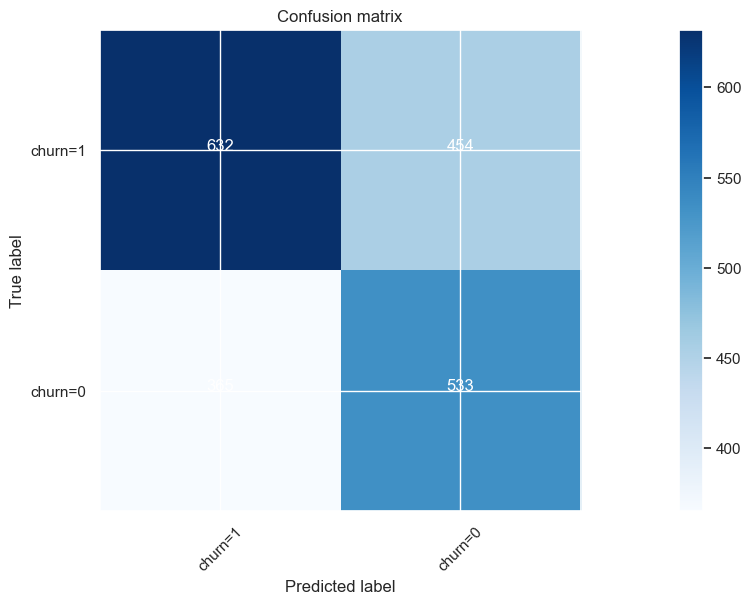

In [122]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['churn=1','churn=0'],normalize= False,  title='Confusion matrix')

### En esta matriz de confusión vale la pena dedicar algunas líneas, puesto que indica que tan bien o mal esta el modelo prediciendo:

[1451 1078]  total de casos=23090
 [1100  ]]
1. Se tienen 989 casos marcados como 0 y que efectivamente eran 0. 
    1. De todos los casos que eran efectivamente cero (1100 + 989 = 2.089) el 0,473% (989/2089) fue correctamente predecido -> Esta métrica es conocida como calidad
    1. De todos los casos que el modelo marco como 0 (1078 + 989 = 2.067) el 0,0,478% (989/2067) eran efectivamente cero -> Esta métrica es conocida como precisión
1. Se tienen 1451 casos marcados como 1 y que efectivamente eran 1.
    1. De todos los casos que eran efectivamente uno (1451 +1078 =  2529) el 0,573%  fue correctamente predecido
    1. De todos los casos que el modelo marco como 1 (1451 + 1100 = 2551) el 0,431%  eran efectivamente uno

### Todo esto se puede observar en el siguiente reporte que se obtiene de directamente de Python

In [123]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.54      0.59      0.57       898
           1       0.63      0.58      0.61      1086

    accuracy                           0.59      1984
   macro avg       0.59      0.59      0.59      1984
weighted avg       0.59      0.59      0.59      1984



F1 Score es una combinación de la precisión y la calidad, indica con que tanta certeza el modelo esta funcionando, se puede decir que en general el modelo tiene un xxxx% de certeza

Otro Score a considerar es el Jaccard Score, y se puede obtener de la siguiente manera

In [124]:
jaccard_score(y_test, yhat,pos_label=0)

0.3942307692307692

xxxxx% como se observa es muy parecido, en este caso, al f1-score

In [125]:
LR.coef_[0]

array([-0.13, -0.46,  0.01,  0.01,  0.02, -0.05,  0.  ,  0.11,  0.09,
       -0.99])

# Como última validación del modelo, se revisa cuanto peso tienen las variables independientes en el resultado de la predicción

In [126]:
def get_feature_importance (LR, feature_names):
    feature_importance = (
        pd.DataFrame(
            {
                'Variable': feature_names,
                'Coeficiente': LR.coef_[0]
            }
        )
        .round(decimals=2) \
        .sort_values('Coeficiente', ascending=False) \
        .style.bar(color=['red', 'green'], align='zero')
    )
    return feature_importance

In [127]:
get_feature_importance(LR, ['Pago','EstadoEntrega','PaisCliente','Categoria','PaisPedido','SegmentoCliente','RegionPedido','DestinoPedido','CiudadCliente',
'ModoEnvio'])

,Variable,Coeficiente
7,DestinoPedido,0.110000
8,CiudadCliente,0.090000
4,PaisPedido,0.020000
2,PaisCliente,0.010000
3,Categoria,0.010000
6,RegionPedido,0.000000
5,SegmentoCliente,-0.050000
0,Pago,-0.130000
1,EstadoEntrega,-0.460000
9,ModoEnvio,-0.990000


INTERPRETAR EL RESULTADO SEGUN LA INCIDENCIA DE CADA VARIABLE------------------

# Conclusiones:
1. Se realizo el análisis inicial de la base de datos, es una base muy limpia, sin missings ni duplicados
1. El análisis exploratorio utilizando principalmente la libreria de seaborn que resultó muy poderosa para darnos información de manera gráfica de las variables
1. Una Regresión Logística fue entrenada y validada con un poder predictivo de XXXXX%

# Clustering

In [128]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import plot, iplot, init_notebook_mode
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.cluster import hierarchy
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

In [ ]:
#Importación de dataset desde github
url = 'https://github.com/ISPC-PP1-2024/proyecto/blob/main/datos/DataCoSupplyChainDataset/DataCoSupplyChainDataset.csv'
df_1 = pd.read_csv(url)

In [147]:
# Se consulta la base de datos
df_1=pd.read_csv('C:\\Users\\Usuario\\Desktop\\2024\\materias\\CDIA\\2semestre\\pp1-cdia23\\ejemplo suply chain\\DataCoSupplyChainDataset.csv\\para jupyter\\DataCoSupplyChainDataset.csv', encoding='latin1', sep=',',  low_memory=False)

In [148]:
df = df_1[df_1['Order Country'].isin(['Argentina', 'Brasil', 'Mexico'])]

#tomar las primeras 100 filas de cada pais para reducir el dataset a fines practicos,

In [149]:
#esto es para probar con un dataset menor a ver si se ven mejores los puntos en los graficos de dispersion
#de los clusters
#---lo que hace es tomar las primeras 100 filas de cada pais filtrado
#---el dataset contiene 300 filas, 100 de argentina, 100 de brasil y 100 de mexico

# Agrupar por país y contar
grouped = df.groupby('Order Country')
counts = grouped.size()

# Función para limitar por país
def limit_by_country(group, limit=100):
    return group.head(limit)

# Aplicar la función y reiniciar el índice
df_filtered = grouped.apply(limit_by_country).reset_index(drop=True)

# Mostrar el DataFrame resultante
#print(df_filtered)
df_filtered.head()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_8712\914935078.py:15: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,TRANSFER,6,4,55.090000,189.949997,Late delivery,1,29,Shop By Sport,Caguas,...,NaN,627,29,NaN,http://images.acmesports.sports/Under+Armour+G...,Under Armour Girls' Toddler Spine Surge Runni,39.990002,0,2/13/2017 9:47,Standard Class
1,TRANSFER,6,4,52.500000,187.500000,Late delivery,1,24,Women's Apparel,Caguas,...,NaN,502,24,NaN,http://images.acmesports.sports/Nike+Men%27s+D...,Nike Men's Dri-FIT Victory Golf Polo,50.000000,0,2/13/2017 9:47,Standard Class
2,TRANSFER,2,4,74.089996,284.950012,Advance shipping,0,3,Baseball & Softball,Caguas,...,NaN,44,3,NaN,http://images.acmesports.sports/adidas+Men%27s...,adidas Men's F10 Messi TRX FG Soccer Cleat,59.990002,0,5/2/2015 23:49,Standard Class
3,TRANSFER,3,4,33.220001,293.950012,Advance shipping,0,17,Cleats,Caguas,...,NaN,365,17,NaN,http://images.acmesports.sports/Perfect+Fitnes...,Perfect Fitness Perfect Rip Deck,59.990002,0,2/9/2017 6:27,Standard Class
4,TRANSFER,6,4,-9.050000,65.580002,Late delivery,1,29,Shop By Sport,Edison,...,NaN,627,29,NaN,http://images.acmesports.sports/Under+Armour+G...,Under Armour Girls' Toddler Spine Surge Runni,39.990002,0,3/16/2015 0:15,Standard Class


In [150]:
df=df_filtered

In [151]:
df_filtered.shape

(200, 53)

In [152]:
# con este seguimos trabajando
df.shape

(200, 53)

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 53 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Type                           200 non-null    object 
 1   Days for shipping (real)       200 non-null    int64  
 2   Days for shipment (scheduled)  200 non-null    int64  
 3   Benefit per order              200 non-null    float64
 4   Sales per customer             200 non-null    float64
 5   Delivery Status                200 non-null    object 
 6   Late_delivery_risk             200 non-null    int64  
 7   Category Id                    200 non-null    int64  
 8   Category Name                  200 non-null    object 
 9   Customer City                  200 non-null    object 
 10  Customer Country               200 non-null    object 
 11  Customer Email                 200 non-null    object 
 12  Customer Fname                 200 non-null    obj

In [154]:
# Cantidad de valores nulos por columna
missing_data = df.isna().sum()
print(missing_data[missing_data > 0])

Order Zipcode          200
Product Description    200
dtype: int64


In [155]:
#ELIMINAMOS FILAS DEL DATAFRAME QUE NO USAMOS.
columnas_a_eliminar = ['Sales per customer','Category Id','Customer Email','Customer Fname','Customer Lname',
'Customer Password','Customer State','Customer Street','Customer Zipcode','Department Id','Department Name','Latitude',
'Longitude','Market','Order City','Order Customer Id','Order Item Cardprod Id','Order Item Discount', 'Order Item Discount Rate',
'Order Item Profit Ratio','Product Image','Product Description','Order Zipcode','Product Status']

df = df.drop(columns=columnas_a_eliminar, axis=1)

In [156]:
df.columns

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Delivery Status', 'Late_delivery_risk',
       'Category Name', 'Customer City', 'Customer Country', 'Customer Id',
       'Customer Segment', 'Order Country', 'order date (DateOrders)',
       'Order Id', 'Order Item Id', 'Order Item Product Price',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status',
       'Product Card Id', 'Product Category Id', 'Product Name',
       'Product Price', 'shipping date (DateOrders)', 'Shipping Mode'],
      dtype='object')

In [157]:
#CAMBIAR LAS COLUMNAS A ESPAÑOL
#// prueba para cambiar los valores de las columnas a español
df_espanol=df

In [158]:
#renombro la columna porque tiene espacios
df_espanol.rename(columns={'Category Name':'Categoria',
                           'Type':'Pago'
                           ,'Days for shipping (real)':'DiasEnvio(Real)'
                           , 'Days for shipment (scheduled)':'DiasEnvio(Programado)'
                           , 'Benefit per order':'BeneficioPorPedido'
                           , 'Delivery Status':'EstadoEntrega'
                           , 'Late_delivery_risk':'RiesgoEntregaTardia'
                           , 'Category Name':'Categoria'
                           , 'Customer Country':'PaisCliente'
                           , 'Customer Id':'IDCliente'
                           , 'Customer Segment':'SegmentoCliente'
                           , 'Order Country':'PaisPedido'
                           , 'order date (DateOrders)':'FechaPedido'
                           , 'Order Id':'IDPedido'
                           , 'Order Item Id':'IDArticuloPedido'
                           , 'Order Item Product Price':'PrecioArticuloPedido'
                           , 'Order Item Quantity':'CantidadArticulosPedido'
                           , 'Sales':'Ventas'
                           , 'Order Item Total':'TotalArticulosPedido'
                           , 'Order Profit Per Order':'GananciaPorPedido'
                           , 'Order Region':'RegionPedido'
                           , 'Order State':'DestinoPedido'
                           , 'Order Status':'EstadoPedido'
                           , 'Product Card Id':'IDProducto'
                           , 'Product Category Id':'CategoriaProducto'
                           , 'Product Name':'NombreProducto'
                           , 'Product Price':'PrecioProducto'
                           , 'shipping date (DateOrders)':'FechaEnvio'
                           , 'Shipping Mode':'ModoEnvio' 
                           , 'Customer City':'CiudadCliente'
                          
                          },inplace=True)

In [159]:
# Columnas traducidas
df_espanol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Pago                     200 non-null    object 
 1   DiasEnvio(Real)          200 non-null    int64  
 2   DiasEnvio(Programado)    200 non-null    int64  
 3   BeneficioPorPedido       200 non-null    float64
 4   EstadoEntrega            200 non-null    object 
 5   RiesgoEntregaTardia      200 non-null    int64  
 6   Categoria                200 non-null    object 
 7   CiudadCliente            200 non-null    object 
 8   PaisCliente              200 non-null    object 
 9   IDCliente                200 non-null    int64  
 10  SegmentoCliente          200 non-null    object 
 11  PaisPedido               200 non-null    object 
 12  FechaPedido              200 non-null    object 
 13  IDPedido                 200 non-null    int64  
 14  IDArticuloPedido         2

In [160]:
#tamaño del nuevo dataframe
df_espanol.shape

(200, 29)

In [161]:
df_espanol.nunique()

Pago                         4
DiasEnvio(Real)              7
DiasEnvio(Programado)        4
BeneficioPorPedido         197
EstadoEntrega                4
RiesgoEntregaTardia          2
Categoria                   17
CiudadCliente               61
PaisCliente                  2
IDCliente                  151
SegmentoCliente              3
PaisPedido                   2
FechaPedido                152
IDPedido                   152
IDArticuloPedido           200
PrecioArticuloPedido        19
CantidadArticulosPedido      5
Ventas                      44
TotalArticulosPedido       164
GananciaPorPedido          197
RegionPedido                 1
DestinoPedido               34
EstadoPedido                 9
IDProducto                  27
CategoriaProducto           18
NombreProducto              27
PrecioProducto              19
FechaEnvio                 152
ModoEnvio                    4
dtype: int64

In [162]:
# verificar filas duplicadas
duplicados=df_espanol[df.duplicated()]
if duplicados.empty:
    print("No hay filas duplicadas en el DataFrame.")
else:
    print("Las siguientes filas están duplicadas:")
    print(duplicados)

No hay filas duplicadas en el DataFrame.


In [163]:
# verificar espacios vacios
hay_vacios = df_espanol.isna().any().any()

if hay_vacios:
    print("El DataFrame contiene valores vacíos.")
else:
    print("El DataFrame no contiene valores vacíos.")

El DataFrame no contiene valores vacíos.


In [164]:
# convertir las columnas no numericas a numericas y con formato sin puntos

import re
import pandas as pd

def clean_price(price_str):
    if pd.isna(price_str):
        return None
    
    # Convertir a string si no lo es
    price_str = str(price_str)
    
    # Eliminar espacios en blanco y caracteres no numéricos excepto punto y coma
    cleaned = re.sub(r'[^\d.,]', '', price_str)
    
    # Reemplazar coma por punto si hay más de un punto (asumiendo que la coma es el separador decimal)
    if cleaned.count('.') > 1 and ',' in cleaned:
        cleaned = cleaned.replace(',', '.')
    
    # Si hay más de un punto, asumimos que todos menos el último son separadores de miles
    parts = cleaned.split('.')
    if len(parts) > 2:
        integer_part = ''.join(parts[:-1])
        decimal_part = parts[-1]
        cleaned = f"{integer_part}.{decimal_part}"
    
    try:
        return float(cleaned)
    except ValueError:
        print(f"No se pudo convertir: {price_str}")
        return None

# Aplicar la función a la columna 'Product Price' y mostrar los resultados
df_espanol['Clean Price'] = df_espanol['PrecioProducto'].apply(clean_price)

# Mostrar filas donde la limpieza falló
failed_conversions = df_espanol[df_espanol['PrecioProducto'].isna()]
print("Filas donde la conversión falló:")
print(failed_conversions[['PrecioProducto', 'Clean Price']])

# Calcular la mediana de los precios limpios
median_prices = df_espanol.groupby('Categoria')['Clean Price'].median()
print("\nMediana de precios de productos segun categoria:")
print(median_prices)

# Calcular la media de los precios limpios
media_prices = df_espanol.groupby('Categoria')['Clean Price'].mean()
print("\nMedia de precios  de productos segun categoria:")
print(media_prices)
# Calcular la desviacion estandar de los precios limpios
std_prices = df_espanol.groupby('Categoria')['Clean Price'].std()
print("\nDesviacion estandar de productos segun categoria:")
print(std_prices)

# Mostrar estadísticas de la columna de precios limpios
print("\nEstadísticas de la columna de precio de productos:")
print(df_espanol['Clean Price'].describe())

Filas donde la conversión falló:
Empty DataFrame
Columns: [PrecioProducto, Clean Price]
Index: []

Mediana de precios de productos segun categoria:
Categoria
Accessories             24.990000
Baseball & Softball     59.990002
Boxing & MMA            72.480000
Camping & Hiking       299.980011
Cardio Equipment        99.989998
Cleats                  59.990002
Electronics             49.990002
Fishing                399.980011
Fitness Accessories     34.990002
Girls' Apparel          70.000000
Golf Balls              19.990000
Hockey                  22.000000
Lacrosse                24.990000
Men's Footwear         129.990005
Shop By Sport           39.990002
Tennis & Racquet        44.990002
Women's Apparel         50.000000
Name: Clean Price, dtype: float64

Media de precios  de productos segun categoria:
Categoria
Accessories             24.990000
Baseball & Softball     51.656668
Boxing & MMA            72.480000
Camping & Hiking       299.980011
Cardio Equipment        94.157498
C

In [165]:
# convertir las columnas no numericas a numericas y con formato sin puntos

import re
import pandas as pd

def clean_Beneficio_por_pedido(benPP_str):
    if pd.isna(benPP_str):
        return None
    
    # Convertir a string si no lo es
    benPP_str = str(benPP_str)
    
    # Eliminar espacios en blanco y caracteres no numéricos excepto punto y coma
    cleaned = re.sub(r'[^\d.,]', '', benPP_str)
    
    # Reemplazar coma por punto si hay más de un punto (asumiendo que la coma es el separador decimal)
    if cleaned.count('.') > 1 and ',' in cleaned:
        cleaned = cleaned.replace(',', '.')
    
    # Si hay más de un punto, asumimos que todos menos el último son separadores de miles
    parts = cleaned.split('.')
    if len(parts) > 2:
        integer_part = ''.join(parts[:-1])
        decimal_part = parts[-1]
        cleaned = f"{integer_part}.{decimal_part}"
    
    try:
        return float(cleaned)
    except ValueError:
        print(f"No se pudo convertir: {benPP_str}")
        return None

# Aplicar la función a la columna 'Benefit per order' y mostrar los resultados
df_espanol['clean_Beneficio_por_pedido'] = df_espanol['BeneficioPorPedido'].apply(clean_Beneficio_por_pedido)

# Mostrar filas donde la limpieza falló
failed_conversions = df_espanol[df_espanol['clean_Beneficio_por_pedido'].isna()]
print("Filas donde la conversión falló:")
print(failed_conversions[['BeneficioPorPedido', 'clean_Beneficio_por_pedido']])

# Calcular la mediana -Beneficio por orden limpio
median_prices = df_espanol.groupby('IDPedido')['clean_Beneficio_por_pedido'].median()
print("\nMediana de precios por producto:")
print(median_prices)
# Calcular la media -Beneficio por orden limpio
media_prices = df_espanol.groupby('IDPedido')['clean_Beneficio_por_pedido'].mean()
print("\nMedia de precios  de productos segun categoria:")
print(media_prices)
# Calcular la desviacion estandar -Beneficio por orden limpio
std_prices = df_espanol.groupby('IDPedido')['clean_Beneficio_por_pedido'].std()
print("\nDesviacion estandar de productos segun categoria:")
print(std_prices)

# Mostrar estadísticas de la columna de precios limpios
print("\nEstadísticas de la columna Beneficio por Pedido:")
print(df_espanol['clean_Beneficio_por_pedido'].describe())

Filas donde la conversión falló:
Empty DataFrame
Columns: [BeneficioPorPedido, clean_Beneficio_por_pedido]
Index: []

Mediana de precios por producto:
IDPedido
117      13.860000
135      17.430000
212      34.099998
738      29.569999
1311     24.750000
           ...    
61192    59.060001
61346    34.990002
61382    53.299999
61419    98.000000
61515    23.180000
Name: clean_Beneficio_por_pedido, Length: 152, dtype: float64

Media de precios  de productos segun categoria:
IDPedido
117      13.860000
135      17.430000
212      34.099998
738      29.569999
1311     24.003333
           ...    
61192    59.060001
61346    34.990002
61382    53.299999
61419    98.000000
61515    23.180000
Name: clean_Beneficio_por_pedido, Length: 152, dtype: float64

Desviacion estandar de productos segun categoria:
IDPedido
117            NaN
135            NaN
212            NaN
738      34.238109
1311     10.390141
           ...    
61192          NaN
61346          NaN
61382          NaN
61419    

In [166]:
import re
import pandas as pd

def clean_Beneficio_por_pedido(benPP_str):
    if pd.isna(benPP_str):
        return None
    
    # Convertir a string si no lo es
    benPP_str = str(benPP_str)
    
    # Eliminar espacios en blanco y caracteres no numéricos excepto punto y coma
    cleaned = re.sub(r'[^\d.,]', '', benPP_str)
    
    # Reemplazar coma por punto si hay más de un punto (asumiendo que la coma es el separador decimal)
    if cleaned.count('.') > 1 and ',' in cleaned:
        cleaned = cleaned.replace(',', '.')
    
    # Si hay más de un punto, asumimos que todos menos el último son separadores de miles
    parts = cleaned.split('.')
    if len(parts) > 2:
        integer_part = ''.join(parts[:-1])
        decimal_part = parts[-1]
        cleaned = f"{integer_part}.{decimal_part}"
    
    try:
        return float(cleaned)
    except ValueError:
        print(f"No se pudo convertir: {benPP_str}")
        return None

# Aplicar la función a la columna 'Benefit per order' y mostrar los resultados
df_espanol['clean_Ventas'] = df_espanol['Ventas'].apply(clean_Beneficio_por_pedido)

# Mostrar filas donde la limpieza falló
failed_conversions = df_espanol[df_espanol['clean_Ventas'].isna()]
print("Filas donde la conversión falló:")
print(failed_conversions[['Ventas', 'clean_Ventas']])

# Calcular la mediana -Beneficio por orden limpio
median_prices = df_espanol.groupby('IDPedido')['clean_Ventas'].median()
print("\nMediana de precios por producto:")
print(median_prices)
# Calcular la media -Beneficio por orden limpio
media_prices = df_espanol.groupby('IDPedido')['clean_Ventas'].mean()
print("\nMedia de precios  de productos segun categoria:")
print(media_prices)
# Calcular la desviacion estandar -Beneficio por orden limpio
std_prices = df_espanol.groupby('IDPedido')['clean_Ventas'].std()
print("\nDesviacion estandar de productos segun categoria:")
print(std_prices)

# Mostrar estadísticas de la columna de precios limpios
print("\nEstadísticas de la columna Beneficio por Pedido:")
print(df_espanol['clean_Ventas'].describe())

Filas donde la conversión falló:
Empty DataFrame
Columns: [Ventas, clean_Ventas]
Index: []

Mediana de precios por producto:
IDPedido
117       66.000000
135      119.980003
212      159.960007
738      130.980003
1311      99.989998
            ...    
61192    449.950012
61346    199.949997
61382    129.990005
61419    250.000000
61515     59.990002
Name: clean_Ventas, Length: 152, dtype: float64

Media de precios  de productos segun categoria:
IDPedido
117       66.000000
135      119.980003
212      159.960007
738      130.980003
1311      86.656666
            ...    
61192    449.950012
61346    199.949997
61382    129.990005
61419    250.000000
61515     59.990002
Name: clean_Ventas, Length: 152, dtype: float64

Desviacion estandar de productos segun categoria:
IDPedido
117             NaN
135             NaN
212             NaN
738      154.120999
1311      23.094009
            ...    
61192           NaN
61346           NaN
61382           NaN
61419           NaN
61515      0

# AQUI COMENZAMOS CON EL CLUSTERING USANDO EL CODIGO ANTERIOR

In [167]:
pd.DataFrame(df_espanol.describe()).style.set_caption("Summary Statistics of Numeric Variables")

,DiasEnvio(Real),DiasEnvio(Programado),BeneficioPorPedido,RiesgoEntregaTardia,IDCliente,IDPedido,IDArticuloPedido,PrecioArticuloPedido,CantidadArticulosPedido,Ventas,TotalArticulosPedido,GananciaPorPedido,IDProducto,CategoriaProducto,PrecioProducto,Clean Price,clean_Beneficio_por_pedido,clean_Ventas
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,3.645000,3.230000,25.065700,0.500000,6810.145000,29433.165000,73592.740000,75.513051,2.960000,174.781452,157.354601,25.065700,426.260000,19.885000,75.513051,75.513051,49.493500,174.781452
std,1.568847,1.250969,70.721360,0.501255,3554.197325,25063.081571,62684.251195,76.721549,1.603514,107.654600,98.696331,70.721360,237.025373,10.537408,76.721549,76.721549,56.311998,107.654600
min,0.000000,0.000000,-459.000000,0.000000,17.000000,117.000000,272.000000,19.990000,1.000000,22.000000,18.480000,-459.000000,37.000000,3.000000,19.990000,19.990000,0.000000,22.000000
25%,2.000000,2.000000,9.070000,0.000000,3983.000000,5668.000000,14127.000000,39.990002,1.000000,99.989998,80.000000,9.070000,191.000000,9.000000,39.990002,39.990002,14.267500,99.989998
50%,4.000000,4.000000,27.315001,0.500000,7718.000000,10114.500000,25273.500000,50.000000,3.000000,129.990005,126.739998,27.315001,403.000000,18.000000,50.000000,50.000000,33.995001,129.990005
75%,5.000000,4.000000,52.264999,1.000000,9574.000000,54236.000000,135603.250000,92.489998,5.000000,250.000000,217.500000,52.264999,502.000000,24.000000,92.489998,92.489998,59.605001,250.000000
max,6.000000,4.000000,232.729996,1.000000,12431.000000,61515.000000,153828.000000,399.980011,5.000000,499.950012,474.950012,232.729996,1004.000000,45.000000,399.980011,399.980011,459.000000,499.950012


In [168]:
pd.DataFrame(df_espanol.select_dtypes('object').describe().T).style.set_caption("Summary Statistics of Categorical Variables")

,count,unique,top,freq
Pago,200,4,TRANSFER,73
EstadoEntrega,200,4,Late delivery,100
Categoria,200,17,Women's Apparel,44
CiudadCliente,200,61,Caguas,119
PaisCliente,200,2,Puerto Rico,122
SegmentoCliente,200,3,Consumer,82
PaisPedido,200,2,Argentina,100
FechaPedido,200,152,3/22/2015 19:09,5
RegionPedido,200,1,South America,200
DestinoPedido,200,34,Buenos Aires,49


# Analisis EDA

In [169]:
df_espanol

,Pago,DiasEnvio(Real),DiasEnvio(Programado),BeneficioPorPedido,EstadoEntrega,RiesgoEntregaTardia,Categoria,CiudadCliente,PaisCliente,IDCliente,...,EstadoPedido,IDProducto,CategoriaProducto,NombreProducto,PrecioProducto,FechaEnvio,ModoEnvio,Clean Price,clean_Beneficio_por_pedido,clean_Ventas
0,TRANSFER,6,4,55.090000,Late delivery,1,Shop By Sport,Caguas,Puerto Rico,6398,...,PENDING,627,29,Under Armour Girls' Toddler Spine Surge Runni,39.990002,2/13/2017 9:47,Standard Class,39.990002,55.090000,199.949997
1,TRANSFER,6,4,52.500000,Late delivery,1,Women's Apparel,Caguas,Puerto Rico,6398,...,PENDING,502,24,Nike Men's Dri-FIT Victory Golf Polo,50.000000,2/13/2017 9:47,Standard Class,50.000000,52.500000,250.000000
2,TRANSFER,2,4,74.089996,Advance shipping,0,Baseball & Softball,Caguas,Puerto Rico,1273,...,PROCESSING,44,3,adidas Men's F10 Messi TRX FG Soccer Cleat,59.990002,5/2/2015 23:49,Standard Class,59.990002,74.089996,299.950012
3,TRANSFER,3,4,33.220001,Advance shipping,0,Cleats,Caguas,Puerto Rico,11106,...,PROCESSING,365,17,Perfect Fitness Perfect Rip Deck,59.990002,2/9/2017 6:27,Standard Class,59.990002,33.220001,299.950012
4,TRANSFER,6,4,-9.050000,Late delivery,1,Shop By Sport,Edison,EE. UU.,9884,...,PROCESSING,627,29,Under Armour Girls' Toddler Spine Surge Runni,39.990002,3/16/2015 0:15,Standard Class,39.990002,9.050000,79.980003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,PAYMENT,3,4,43.869999,Advance shipping,0,Men's Footwear,Caguas,Puerto Rico,5425,...,PENDING_PAYMENT,403,18,Nike Men's CJ Elite 2 TD Football Cleat,129.990005,2/24/2015 23:34,Standard Class,129.990005,43.869999,129.990005
196,PAYMENT,2,4,18.320000,Advance shipping,0,Women's Apparel,Caguas,Puerto Rico,8984,...,PENDING_PAYMENT,502,24,Nike Men's Dri-FIT Victory Golf Polo,50.000000,1/22/2015 18:43,Standard Class,50.000000,18.320000,50.000000
197,PAYMENT,3,4,-2.840000,Advance shipping,0,Women's Apparel,Caguas,Puerto Rico,116,...,PENDING_PAYMENT,502,24,Nike Men's Dri-FIT Victory Golf Polo,50.000000,3/30/2015 11:37,Standard Class,50.000000,2.840000,50.000000
198,PAYMENT,4,4,96.000000,Shipping on time,0,Fishing,Caguas,Puerto Rico,2582,...,PENDING_PAYMENT,1004,45,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,6/1/2015 9:25,Standard Class,399.980011,96.000000,399.980011


In [170]:
init_notebook_mode(connected=True)
plot_df=df_espanol.copy()
plot_df['clean_Beneficio_por_pedido']=plot_df['clean_Beneficio_por_pedido'].div(10000)
p1=plot_df.groupby('PaisPedido')['DiasEnvio(Real)'].mean().round(0).astype(int).reset_index()
p2=plot_df.groupby('PaisPedido')['clean_Beneficio_por_pedido'].mean().reset_index()
p3=plot_df.groupby('PaisPedido')['DiasEnvio(Programado)'].mean().round(0).astype(int).reset_index()

temp = dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12)))
fig = make_subplots(rows=3, cols=2,
                    subplot_titles=("Distribucion de dias reales por pais","Media Dias Entrega Real por Pais ",  
                                    "Distribucion de dias programados por pais", "Media de dias programados por pais",
                                    "Distribution of GananciaPorPedido por pais", "Media de Beneficio por pais")
                   )

In [171]:
fig.add_trace(go.Histogram(x=plot_df[plot_df.PaisPedido=="Argentina"]['DiasEnvio(Real)'], histnorm='probability density', 
                           marker=dict(color='#508B8D',opacity=0.7, line=dict(width=1, color='#000000')), 
                           nbinsx=20, name="Argentina"),
              row=1, col=1)
fig.add_trace(go.Histogram(x=plot_df[plot_df.PaisPedido=="Brasil"]['DiasEnvio(Real)'], histnorm='probability density', 
                           marker=dict(color='#F3D6CB',opacity=0.7, line=dict(width=1, color='#000000')),
                           nbinsx=20, name="Brasil"),
              row=1, col=1)
fig.add_trace(go.Histogram(x=plot_df[plot_df.PaisPedido=="Mexico"]['DiasEnvio(Real)'], histnorm='probability density', 
                           marker=dict(color='#F3ffCB',opacity=0.7, line=dict(width=1, color='#000000')),
                           nbinsx=20, name="Mexico"),
              row=1, col=1)

fig.add_trace(go.Bar(x=p1['PaisPedido'], y=p1['DiasEnvio(Real)'], text=p1['DiasEnvio(Real)'], texttemplate='%{text} ', textposition='outside',
                     marker=dict(color=['#508B8D', '#F0CABD'], opacity=0.8),width=.8,
                     hovertemplate='Average Age Among %{x} = %{y} <extra></extra>', showlegend=False),
              row=1, col=2)



fig.add_trace(go.Histogram(x=plot_df[plot_df.PaisPedido=='Argentina']['clean_Beneficio_por_pedido'], histnorm='probability density', 
                           marker=dict(color='#508B8D', line=dict(width=1, color='#000000')), 
                           opacity=0.7, name="Argentina", nbinsx=20, showlegend=False),
              row=2, col=1)
fig.add_trace(go.Histogram(x=plot_df[plot_df.PaisPedido=='Brasil']['clean_Beneficio_por_pedido'], histnorm='probability density', 
                           marker=dict(color='#F3D6CB', line=dict(width=1, color='#000000')),
                           opacity=0.7, name="Brasil", nbinsx=20, showlegend=False),
              row=2, col=1)
fig.add_trace(go.Histogram(x=plot_df[plot_df.PaisPedido=="Mexico"]['clean_Beneficio_por_pedido'], histnorm='probability density', 
                           marker=dict(color='#F3ffCB',opacity=0.7, line=dict(width=1, color='#000000')),
                           nbinsx=20, name="Mexico"),
              row=2, col=1)
fig.add_trace(go.Bar(x=p2['PaisPedido'], y=p2['clean_Beneficio_por_pedido'], text=p2['clean_Beneficio_por_pedido'], 
                     texttemplate='%{text}', textposition='outside',
                     marker=dict(color=['#508B8D', '#F0CABD'], opacity=0.8),width=.8,
                     hovertemplate='Average Spending Score Among %{x} = %{y}<extra></extra>', showlegend=False),
              row=2, col=2)


fig.add_trace(go.Histogram(x=plot_df[plot_df.PaisPedido=="Argentina"]['DiasEnvio(Programado)'], histnorm='probability density', 
                           marker=dict(color='#508B8D',opacity=0.7, line=dict(width=1, color='#000000')), 
                           nbinsx=20, name="Argentina"),
              row=3, col=1)
fig.add_trace(go.Histogram(x=plot_df[plot_df.PaisPedido=="Brasil"]['DiasEnvio(Programado)'], histnorm='probability density', 
                           marker=dict(color='#F3D6CB',opacity=0.7, line=dict(width=1, color='#000000')),
                           nbinsx=20, name="Brasil"),
              row=3, col=1)
fig.add_trace(go.Histogram(x=plot_df[plot_df.PaisPedido=="Mexico"]['DiasEnvio(Programado)'], histnorm='probability density', 
                           marker=dict(color='#F3ffCB',opacity=0.7, line=dict(width=1, color='#000000')),
                           nbinsx=20, name="Mexico"),
              row=3, col=1)

fig.add_trace(go.Bar(x=p3['PaisPedido'], y=p3['DiasEnvio(Programado)'], text=p3['DiasEnvio(Programado)'], texttemplate='%{text} ', textposition='outside',
                     marker=dict(color=['#508B8D', '#F0CABD'], opacity=0.8),width=.8,
                     hovertemplate='Average Age Among %{x} = %{y} <extra></extra>', showlegend=False),
              row=3, col=2)



fig.update_traces(marker=dict(line=dict(width=1, color='#000000')))
fig.update_layout(template=temp,barmode='overlay', height=1500, width=700,
                  legend=dict(orientation="h", yanchor="bottom", xanchor="right", y=1.03, x=.97),
                  xaxis1_title="DiasEnvio(Real)", yaxis1_title='Densidad de Probabilidad', 
                  xaxis2_title="PaisPedido", yaxis2_title="DiasEnvio(Real)", yaxis2_range=[0,45],
                  xaxis3_title="clean_Beneficio_por_pedido, $", yaxis3_title='Densidad de Probabilidad', 
                  xaxis4_title="PaisPedido", yaxis4_title="clean_Beneficio_por_pedido, $", yaxis4_range=[0,69e3],
                  xaxis5_title="DiasEnvio(Programado)", yaxis5_title='Densidad de Probabilidad', 
                  xaxis6_title="PaisPedido", yaxis6_title="DiasEnvio(Programado)", yaxis6_range=[0,59]
                 )
fig.show()


In [172]:
# Seleccionamos solo las columnas de interés
columnas_deseadas = ['PaisPedido','DiasEnvio(Real)', 'DiasEnvio(Programado)', 'clean_Beneficio_por_pedido']
plot_df_reducido = plot_df[columnas_deseadas]

# por partes
columnas_EnvioReal = ['PaisPedido','DiasEnvio(Real)']
plot_df_reducido1 = plot_df[columnas_EnvioReal]
# por partes
columnas_EnvioProgramado = ['PaisPedido','DiasEnvio(Programado)']
plot_df_reducido2 = plot_df[columnas_EnvioProgramado]
# por partes
columnas_Beneficio = ['PaisPedido','clean_Beneficio_por_pedido']
plot_df_reducido3 = plot_df[columnas_Beneficio]


In [173]:
# Pairplots

fig = ff.create_scatterplotmatrix(plot_df_reducido1, diag='box', index='PaisPedido', colormap=['#508B8D', '#F0CABD']) 
fig.update_traces(marker=dict(size=9, opacity=0.85, line=dict(width=1, color='#F7F7F7')))
fig.update_layout(title="Envio real segun pais", template=temp, 
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, x=.35),
                  height=450, width=350)
fig.show() 

In [174]:
# Pairplots

fig = ff.create_scatterplotmatrix(plot_df_reducido2, diag='box', index='PaisPedido', colormap=['#508B8D', '#F0CABD']) 
fig.update_traces(marker=dict(size=9, opacity=0.85, line=dict(width=1, color='#F7F7F7')))
fig.update_layout(title="Envio programado segun pais", template=temp, 
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, x=.35),
                  height=450, width=350)
fig.show() 

In [175]:
fig = ff.create_scatterplotmatrix(plot_df_reducido3, diag='box', index='PaisPedido', colormap=['#508B8D', '#F0CABD']) 
fig.update_traces(marker=dict(size=9, opacity=0.85, line=dict(width=1, color='#F7F7F7')))
fig.update_layout(title="Beneficio por pedido segun pais", template=temp, 
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, x=.35),
                  height=450, width=350)
fig.show() 

In [176]:
plot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Pago                        200 non-null    object 
 1   DiasEnvio(Real)             200 non-null    int64  
 2   DiasEnvio(Programado)       200 non-null    int64  
 3   BeneficioPorPedido          200 non-null    float64
 4   EstadoEntrega               200 non-null    object 
 5   RiesgoEntregaTardia         200 non-null    int64  
 6   Categoria                   200 non-null    object 
 7   CiudadCliente               200 non-null    object 
 8   PaisCliente                 200 non-null    object 
 9   IDCliente                   200 non-null    int64  
 10  SegmentoCliente             200 non-null    object 
 11  PaisPedido                  200 non-null    object 
 12  FechaPedido                 200 non-null    object 
 13  IDPedido                    200 non

In [177]:
# Seleccionamos solo las columnas de interés
columnas_deseadas = ['RiesgoEntregaTardia','DiasEnvio(Real)', 'DiasEnvio(Programado)', 'clean_Beneficio_por_pedido','IDCliente','IDPedido','CantidadArticulosPedido', 'IDProducto','CategoriaProducto','Clean Price']
plot_df_reducido = plot_df[columnas_deseadas]

# --- si quiero variables categoricas, debo convertirlas a numeros 

In [178]:
# Correlaciones de interes
corr=plot_df_reducido.corr()
x = corr.columns.tolist() 
y = corr.index.tolist()
z = corr.values
text = corr.values.round(2)

fig = ff.create_annotated_heatmap(z=z, x=x, y=y, annotation_text=text, colorscale='mint', 
                                  reversescale=True, showscale=True,
                                  hovertemplate="Correlation of %{x} and %{y}= %{z:.3f}")
fig.update_layout(template=temp, title="Correlaciones de interes", yaxis_tickangle=-30)
fig.show()


Resumen de EDA

En general, 
1-las distribuciones son bastante proporcionales entre ellas
<br>2- Según las correlaciones y los diagramas de dispersión, las variables en el conjunto de datos no tienen relaciones muy fuertes entre sí. 

falta:
- analisis detalle de cada variable de los graficos

# Agrupamientos

Agrupamiento de K-Means

El agrupamiento de K-Means es un método de agrupamiento simple pero poderoso que crea k segmentos distintos de los datos donde la variación dentro de los grupos es lo más pequeña posible. 
<br>1- Para encontrar el número óptimo de grupos, se prueban diferentes valores de k y se calcula la inercia, o el puntaje de distorsión, para cada modelo. 
<br>2-La inercia mide la similitud de los grupos calculando la distancia total entre los puntos de datos y su centro de grupo más cercano. 
<br>3- Los grupos con observaciones similares tienden a tener distancias más pequeñas entre ellos y un puntaje de distorsión más bajo en general.

# hay que poner numericos las variables categoricas para poder hacer la grafica

In [179]:
from sklearn.preprocessing import LabelEncoder

In [180]:
plot_df1=df_espanol.copy()

In [181]:
#Realizo label encoder para las no numericas
label_encoder_Pago = LabelEncoder()
label_encoder_EstadoEntrega = LabelEncoder()
label_encoder_PaisCliente = LabelEncoder()
label_encoder_Categoria = LabelEncoder()
label_encoder_PaisPedido = LabelEncoder()
label_encoder_SegmentoCliente = LabelEncoder()
label_encoder_RegionPedido = LabelEncoder()
label_encoder_DestinoPedido = LabelEncoder()
label_encoder_EstadoPedido = LabelEncoder()
label_encoder_CiudadCliente  = LabelEncoder()
label_encoder_TotalArticulosPedido = LabelEncoder()
label_encoder_NombreProducto = LabelEncoder()
label_encoder_ModoEnvio=LabelEncoder()


In [182]:
columnas_a_eliminar = ['FechaEnvio','FechaPedido','BeneficioPorPedido','PrecioArticuloPedido','Ventas','GananciaPorPedido'
,'PrecioArticuloPedido','Ventas','TotalArticulosPedido','PrecioProducto']
plot_df1 = plot_df1.drop(columns=columnas_a_eliminar)

In [183]:
plot_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Pago                        200 non-null    object 
 1   DiasEnvio(Real)             200 non-null    int64  
 2   DiasEnvio(Programado)       200 non-null    int64  
 3   EstadoEntrega               200 non-null    object 
 4   RiesgoEntregaTardia         200 non-null    int64  
 5   Categoria                   200 non-null    object 
 6   CiudadCliente               200 non-null    object 
 7   PaisCliente                 200 non-null    object 
 8   IDCliente                   200 non-null    int64  
 9   SegmentoCliente             200 non-null    object 
 10  PaisPedido                  200 non-null    object 
 11  IDPedido                    200 non-null    int64  
 12  IDArticuloPedido            200 non-null    int64  
 13  CantidadArticulosPedido     200 non

In [184]:
plot_df1['Pago'] = label_encoder_Pago.fit_transform(plot_df['Pago'])
plot_df1['EstadoEntrega'] = label_encoder_EstadoEntrega.fit_transform(plot_df['EstadoEntrega'])
plot_df1['PaisCliente'] = label_encoder_PaisCliente.fit_transform(plot_df['PaisCliente'])
plot_df1['Categoria'] = label_encoder_Categoria.fit_transform(plot_df['Categoria'])
plot_df1['PaisPedido'] = label_encoder_PaisPedido.fit_transform(plot_df['PaisPedido'])
plot_df1['SegmentoCliente'] = label_encoder_SegmentoCliente.fit_transform(plot_df['SegmentoCliente'])
plot_df1['RegionPedido'] = label_encoder_RegionPedido.fit_transform(plot_df['RegionPedido'])
plot_df1['DestinoPedido'] = label_encoder_DestinoPedido.fit_transform(plot_df['DestinoPedido'])
plot_df1['EstadoPedido'] = label_encoder_EstadoPedido.fit_transform(plot_df['EstadoPedido'])
plot_df1['CiudadCliente'] = label_encoder_CiudadCliente .fit_transform(plot_df['CiudadCliente'])
plot_df1['TotalArticulosPedido'] = label_encoder_TotalArticulosPedido.fit_transform(plot_df['TotalArticulosPedido'])
plot_df1['NombreProducto'] = label_encoder_NombreProducto.fit_transform(plot_df['NombreProducto'])
plot_df1['ModoEnvio'] = label_encoder_ModoEnvio.fit_transform(plot_df['ModoEnvio'])

In [185]:
plot_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Pago                        200 non-null    int32  
 1   DiasEnvio(Real)             200 non-null    int64  
 2   DiasEnvio(Programado)       200 non-null    int64  
 3   EstadoEntrega               200 non-null    int32  
 4   RiesgoEntregaTardia         200 non-null    int64  
 5   Categoria                   200 non-null    int32  
 6   CiudadCliente               200 non-null    int32  
 7   PaisCliente                 200 non-null    int32  
 8   IDCliente                   200 non-null    int64  
 9   SegmentoCliente             200 non-null    int32  
 10  PaisPedido                  200 non-null    int32  
 11  IDPedido                    200 non-null    int64  
 12  IDArticuloPedido            200 non-null    int64  
 13  CantidadArticulosPedido     200 non

# aqui ver si hay variables de interes...para tener en cuenta para los clusters

In [186]:
# Correlaciones en general
corr=plot_df1.corr()
x = corr.columns.tolist() 
y = corr.index.tolist()
z = corr.values
text = corr.values.round(2)

fig = ff.create_annotated_heatmap(z=z, x=x, y=y, annotation_text=text, colorscale='mint', 
                                  reversescale=True, showscale=True,
                                  hovertemplate="Correlation of %{x} and %{y}= %{z:.3f}")
fig.update_layout(template=temp, title="Correlaciones entre variable", yaxis_tickangle=-30)
fig.show()

In [187]:
plot_df1.head()

,Pago,DiasEnvio(Real),DiasEnvio(Programado),EstadoEntrega,RiesgoEntregaTardia,Categoria,CiudadCliente,PaisCliente,IDCliente,SegmentoCliente,...,DestinoPedido,EstadoPedido,IDProducto,CategoriaProducto,NombreProducto,ModoEnvio,Clean Price,clean_Beneficio_por_pedido,clean_Ventas,TotalArticulosPedido
0,3,6,4,1,1,14,14,1,6398,0,...,5,5,627,29,19,3,39.990002,55.090000,199.949997,108
1,3,6,4,1,1,16,14,1,6398,0,...,5,5,502,24,7,3,50.000000,52.500000,250.000000,105
2,3,2,4,0,0,1,14,1,1273,0,...,5,7,44,3,25,3,59.990002,74.089996,299.950012,144
3,3,3,4,0,0,5,14,1,11106,0,...,26,7,365,17,11,3,59.990002,33.220001,299.950012,146
4,3,6,4,1,1,14,22,0,9884,1,...,31,7,627,29,19,3,39.990002,9.050000,79.980003,32


In [188]:
#import pandas as pd

def buscar_valor(plot_df1, valor_a_buscar):
    for columna in plot_df1.columns:
        if valor_a_buscar in df[columna].values:
            print(f"El valor {valor_a_buscar} se encontró en la columna: {columna}")

# Ejemplo de uso:
buscar_valor(df, "3.999.000.168")

C:\Users\Usuario\AppData\Local\Temp\ipykernel_8712\3024055918.py:5: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [189]:
# K-Means Clustering
plot_df = plot_df1.copy()
#plot_df['PaisPedido'] = [1 if i == "Argentina" else 0 for i in plot_df.PaisPedido]

k_means = list()
for clust in range(1,16):
    km = KMeans(n_clusters=clust, init='k-means++', random_state=21).fit(plot_df1)
    k_means.append(pd.Series({'Clusters': clust, 
                              'Inertia': km.inertia_,
                              'model': km}))

# Plot results
plot_km = (pd.concat(k_means, axis=1).T
           [['Clusters','Inertia']]
           .set_index('Clusters'))

fig = px.line(plot_km, x=plot_km.index, y='Inertia', markers=True)
fig.add_vline(x=5, line_width=3, line_dash="dash", line_color="darkgrey")
fig.add_annotation(
    xref="x domain",
    yref="y",
    x=.31,
    y=75e3,
    text="Optimal Number of Clusters",
    axref="x domain",
    ayref="y",
    ax=.43,
    ay=12e4,
    arrowhead=2, 
    bordercolor="#585858",
    borderpad=4, 
    bgcolor='white',
    font=dict(size=14)
)
fig.update_traces(line_color='#518C89')
fig.update_layout(template=temp, title="K-Means Clustering Elbow Curve", 
                  xaxis=dict(tickmode = 'linear', showline=True), yaxis=dict(showline=True), width=700)
fig.show()


C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\U

In [190]:
# K-Means with 5 clusters
km = KMeans(n_clusters=5, random_state=21)
km_pred = km.fit_predict(plot_df1)
plot_km=plot_df1.copy()
plot_km['K-Means Cluster'] = km_pred
plot_km=plot_km.sort_values(by='K-Means Cluster')
plot_km['K-Means Cluster'] = plot_km['K-Means Cluster'].astype(str)

# Plot of clusters
fig = px.scatter(plot_km, x="Clean Price", y="TotalArticulosPedido", color="K-Means Cluster", 
                 color_discrete_sequence=px.colors.qualitative.Prism)
fig.update_traces(marker=dict(size=11, opacity=0.75, line=dict(width=1, color='#F7F7F7')))
fig.update_layout(template=temp, title="K-Means Cluster Profiles,<br>Precio vs. Total de Articulos", 
                  width=700, legend_title='Cluster',
                  xaxis=dict(title='Precio, $', showline=True, zeroline=False), 
                  yaxis=dict(title='TotalArticulosPedido', ticksuffix='k', showline=True))
fig.show()

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [191]:
# K-Means with 5 clusters
km = KMeans(n_clusters=5, random_state=21)
km_pred = km.fit_predict(plot_df1)
plot_km=plot_df1.copy()
plot_km['K-Means Cluster'] = km_pred
plot_km=plot_km.sort_values(by='K-Means Cluster')
plot_km['K-Means Cluster'] = plot_km['K-Means Cluster'].astype(str)

# Plot of clusters
fig = px.scatter(plot_km, x="clean_Ventas", y="clean_Beneficio_por_pedido", color="K-Means Cluster", 
                 color_discrete_sequence=px.colors.qualitative.Prism)
fig.update_traces(marker=dict(size=11, opacity=0.75, line=dict(width=1, color='#F7F7F7')))
fig.update_layout(template=temp, title="K-Means Cluster Profiles,<br>Ventas vs. Beneficio por pedido", 
                  width=700, legend_title='Cluster',
                  xaxis=dict(title='Ventas', showline=True, zeroline=False), 
                  yaxis=dict(title='Beneficio_por_pedido, $', ticksuffix='k', showline=True))
fig.show()

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [192]:
# K-Means with 5 clusters
km = KMeans(n_clusters=5, random_state=21)
km_pred = km.fit_predict(plot_df1)
plot_km=plot_df1.copy()
plot_km['K-Means Cluster'] = km_pred
plot_km=plot_km.sort_values(by='K-Means Cluster')
plot_km['K-Means Cluster'] = plot_km['K-Means Cluster'].astype(str)

# Plot of clusters
fig = px.scatter(plot_km, x="clean_Ventas", y="CiudadCliente", color="K-Means Cluster", 
                 color_discrete_sequence=px.colors.qualitative.Prism)
fig.update_traces(marker=dict(size=11, opacity=0.75, line=dict(width=1, color='#F7F7F7')))
fig.update_layout(template=temp, title="K-Means Cluster Profiles,<br>Ventas vs. CiudadCliente", 
                  width=700, legend_title='Cluster',
                  xaxis=dict(title='Venta', showline=True, zeroline=False), 
                  yaxis=dict(title='CiudadCliente', ticksuffix='k', showline=True))
fig.show()

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [193]:
# K-Means with 5 clusters
km = KMeans(n_clusters=5, random_state=21)
km_pred = km.fit_predict(plot_df1)
plot_km=plot_df1.copy()
plot_km['K-Means Cluster'] = km_pred
plot_km=plot_km.sort_values(by='K-Means Cluster')
plot_km['K-Means Cluster'] = plot_km['K-Means Cluster'].astype(str)

# Plot of clusters
fig = px.scatter(plot_km, x="clean_Ventas", y="TotalArticulosPedido", color="K-Means Cluster", 
                 color_discrete_sequence=px.colors.qualitative.Prism)
fig.update_traces(marker=dict(size=11, opacity=0.75, line=dict(width=1, color='#F7F7F7')))
fig.update_layout(template=temp, title="K-Means Cluster Profiles,<br>Ventas vs. TotalArticulosPedido", 
                  width=700, legend_title='Cluster',
                  xaxis=dict(title='Ventas', showline=True, zeroline=False), 
                  yaxis=dict(title='TotalArticulosPedido', ticksuffix='k', showline=True))
fig.show()

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [194]:
# K-Means with 5 clusters
km = KMeans(n_clusters=5, random_state=21)
km_pred = km.fit_predict(plot_df1)
plot_km=plot_df1.copy()
plot_km['K-Means Cluster'] = km_pred
plot_km=plot_km.sort_values(by='K-Means Cluster')
plot_km['K-Means Cluster'] = plot_km['K-Means Cluster'].astype(str)

# Plot of clusters
fig = px.scatter(plot_km, x="CiudadCliente", y="TotalArticulosPedido", color="K-Means Cluster", 
                 color_discrete_sequence=px.colors.qualitative.Prism)
fig.update_traces(marker=dict(size=11, opacity=0.75, line=dict(width=1, color='#F7F7F7')))
fig.update_layout(template=temp, title="K-Means Cluster Profiles,<br>CiudadCliente vs. TotalArticulosPedido", 
                  width=700, legend_title='Cluster',
                  xaxis=dict(title='CiudadCliente', showline=True, zeroline=False), 
                  yaxis=dict(title='TotalArticulosPedido', ticksuffix='k', showline=True))
fig.show()

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [195]:
# K-Means with 5 clusters
km = KMeans(n_clusters=5, random_state=21)
km_pred = km.fit_predict(plot_df1)
plot_km=plot_df1.copy()
plot_km['K-Means Cluster'] = km_pred
plot_km=plot_km.sort_values(by='K-Means Cluster')
plot_km['K-Means Cluster'] = plot_km['K-Means Cluster'].astype(str)

# Plot of clusters
fig = px.scatter(plot_km, x="DiasEnvio(Real)", y="TotalArticulosPedido", color="K-Means Cluster", 
                 color_discrete_sequence=px.colors.qualitative.Prism)
fig.update_traces(marker=dict(size=11, opacity=0.75, line=dict(width=1, color='#F7F7F7')))
fig.update_layout(template=temp, title="K-Means Cluster Profiles,<br>DiasEnvio(Real) vs. TotalArticulosPedido", 
                  width=700, legend_title='Cluster',
                  xaxis=dict(title='DiasEnvio(Real)', showline=True, zeroline=False), 
                  yaxis=dict(title='TotalArticulosPedido', ticksuffix='k', showline=True))
fig.show()

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [196]:
 # K-Means with 5 clusters
km = KMeans(n_clusters=5, random_state=21)
km_pred = km.fit_predict(plot_df1)
plot_km=plot_df1.copy()
plot_km['K-Means Cluster'] = km_pred
plot_km=plot_km.sort_values(by='K-Means Cluster')
plot_km['K-Means Cluster'] = plot_km['K-Means Cluster'].astype(str)

# Plot of clusters
fig = px.scatter(plot_km, x="CantidadArticulosPedido", y="TotalArticulosPedido", color="K-Means Cluster", 
                 color_discrete_sequence=px.colors.qualitative.Prism)
fig.update_traces(marker=dict(size=11, opacity=0.75, line=dict(width=1, color='#F7F7F7')))
fig.update_layout(template=temp, title="K-Means Cluster Profiles,<br>CantidadArticulosPedido vs. TotalArticulosPedido", 
                  width=700, legend_title='Cluster',
                  xaxis=dict(title='CantidadArticulosPedido', showline=True, zeroline=False), 
                  yaxis=dict(title='TotalArticulosPedido', ticksuffix='k', showline=True))
fig.show()

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [197]:
  # K-Means with 5 clusters
km = KMeans(n_clusters=5, random_state=21)
km_pred = km.fit_predict(plot_df1)
plot_km=plot_df1.copy()
plot_km['K-Means Cluster'] = km_pred
plot_km=plot_km.sort_values(by='K-Means Cluster')
plot_km['K-Means Cluster'] = plot_km['K-Means Cluster'].astype(str)

# Plot of clusters
fig = px.scatter(plot_km, x="ModoEnvio", y="Clean Price", color="K-Means Cluster", 
                 color_discrete_sequence=px.colors.qualitative.Prism)
fig.update_traces(marker=dict(size=11, opacity=0.75, line=dict(width=1, color='#F7F7F7')))
fig.update_layout(template=temp, title="K-Means Cluster Profiles,<br>ModoEnvio vs. Precio", 
                  width=700, legend_title='Cluster',
                  xaxis=dict(title='ModoEnvio', showline=True, zeroline=False), 
                  yaxis=dict(title='Precio, $', ticksuffix='k', showline=True))
fig.show()

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [198]:
 # K-Means with 5 clusters
km = KMeans(n_clusters=5, random_state=21)
km_pred = km.fit_predict(plot_df1)
plot_km=plot_df1.copy()
plot_km['K-Means Cluster'] = km_pred
plot_km=plot_km.sort_values(by='K-Means Cluster')
plot_km['K-Means Cluster'] = plot_km['K-Means Cluster'].astype(str)

# Plot of clusters
fig = px.scatter(plot_km, x="Pago", y="Clean Price", color="K-Means Cluster", 
                 color_discrete_sequence=px.colors.qualitative.Prism)
fig.update_traces(marker=dict(size=11, opacity=0.75, line=dict(width=1, color='#F7F7F7')))
fig.update_layout(template=temp, title="K-Means Cluster Profiles,<br>Forma de Pago vs. Precio", 
                  width=700, legend_title='Cluster',
                  xaxis=dict(title='Pagoe', showline=True, zeroline=False), 
                  yaxis=dict(title='Precio, $', ticksuffix='k', showline=True))
fig.show()

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [199]:
# K-Means with 5 clusters
km = KMeans(n_clusters=5, random_state=21)
km_pred = km.fit_predict(plot_df1)
plot_km=plot_df1.copy()
plot_km['K-Means Cluster'] = km_pred
plot_km=plot_km.sort_values(by='K-Means Cluster')
plot_km['K-Means Cluster'] = plot_km['K-Means Cluster'].astype(str)

# Plot of clusters
fig = px.scatter(plot_km, x="Pago", y="Categoria", color="K-Means Cluster", 
                 color_discrete_sequence=px.colors.qualitative.Prism)
fig.update_traces(marker=dict(size=11, opacity=0.75, line=dict(width=1, color='#F7F7F7')))
fig.update_layout(template=temp, title="K-Means Cluster Profiles,<br>Pago vs. Categoria", 
                  width=700, legend_title='Cluster',
                  xaxis=dict(title='Pago', showline=True, zeroline=False), 
                  yaxis=dict(title='Categoria, $', ticksuffix='k', showline=True))
fig.show()

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [200]:
# K-Means with 5 clusters
km = KMeans(n_clusters=5, random_state=21)
km_pred = km.fit_predict(plot_df1)
plot_km=plot_df1.copy()
plot_km['K-Means Cluster'] = km_pred
plot_km=plot_km.sort_values(by='K-Means Cluster')
plot_km['K-Means Cluster'] = plot_km['K-Means Cluster'].astype(str)

# Plot of clusters
fig = px.scatter(plot_km, x="Categoria", y="CiudadCliente", color="K-Means Cluster", 
                 color_discrete_sequence=px.colors.qualitative.Prism)
fig.update_traces(marker=dict(size=11, opacity=0.75, line=dict(width=1, color='#F7F7F7')))
fig.update_layout(template=temp, title="K-Means Cluster Profiles,<br>Categoria vs. CiudadCliente", 
                  width=700, legend_title='Cluster',
                  xaxis=dict(title='Categoria', showline=True, zeroline=False), 
                  yaxis=dict(title='CiudadCliente', ticksuffix='k', showline=True))
fig.show()

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [201]:

    # K-Means with 5 clusters
km = KMeans(n_clusters=5, random_state=21)
km_pred = km.fit_predict(plot_df1)
plot_km=plot_df1.copy()
plot_km['K-Means Cluster'] = km_pred
plot_km=plot_km.sort_values(by='K-Means Cluster')
plot_km['K-Means Cluster'] = plot_km['K-Means Cluster'].astype(str)

# Plot of clusters
fig = px.scatter(plot_km, x="clean_Beneficio_por_pedido", y="clean_Ventas", color="K-Means Cluster", 
                 color_discrete_sequence=px.colors.qualitative.Prism)
fig.update_traces(marker=dict(size=11, opacity=0.75, line=dict(width=1, color='#F7F7F7')))
fig.update_layout(template=temp, title="K-Means Cluster Profiles,<br>Beneficio por pedido vs. Ventas", 
                  width=700, legend_title='Cluster',
                  xaxis=dict(title='Beneficio por pedido', showline=True, zeroline=False), 
                  yaxis=dict(title='Ventas, $', ticksuffix='k', showline=True))
fig.show()

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [202]:

    # K-Means with 5 clusters
km = KMeans(n_clusters=5, random_state=21)
km_pred = km.fit_predict(plot_df1)
plot_km=plot_df1.copy()
plot_km['K-Means Cluster'] = km_pred
plot_km=plot_km.sort_values(by='K-Means Cluster')
plot_km['K-Means Cluster'] = plot_km['K-Means Cluster'].astype(str)

# Plot of clusters
fig = px.scatter(plot_km, x="TotalArticulosPedido", y="Clean Price", color="K-Means Cluster", 
                 color_discrete_sequence=px.colors.qualitative.Prism)
fig.update_traces(marker=dict(size=11, opacity=0.75, line=dict(width=1, color='#F7F7F7')))
fig.update_layout(template=temp, title="K-Means Cluster Profiles,<br>TotalArticulosPedido vs. Precio", 
                  width=700, legend_title='Cluster',
                  xaxis=dict(title='TotalArticulosPedido', showline=True, zeroline=False), 
                  yaxis=dict(title='Precio, $', ticksuffix='k', showline=True))
fig.show()

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [203]:
 # K-Means with 5 clusters
km = KMeans(n_clusters=5, random_state=21)
km_pred = km.fit_predict(plot_df1)
plot_km=plot_df1.copy()
plot_km['K-Means Cluster'] = km_pred
plot_km=plot_km.sort_values(by='K-Means Cluster')
plot_km['K-Means Cluster'] = plot_km['K-Means Cluster'].astype(str)

# Plot of clustersclean_Beneficio_por_pedido
fig = px.scatter(plot_km, x="Categoria", y="IDPedido", color="K-Means Cluster", 
                 color_discrete_sequence=px.colors.qualitative.Prism)
fig.update_traces(marker=dict(size=11, opacity=0.75, line=dict(width=1, color='#F7F7F7')))
fig.update_layout(template=temp, title="K-Means Cluster Profiles,<br>Categoria vs. IDPedido", 
                  width=700, legend_title='Cluster',
                  xaxis=dict(title='Categoria', showline=True, zeroline=False), 
                  yaxis=dict(title='IDPedido', ticksuffix='k', showline=True))
fig.show()

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [204]:
 # K-Means with 5 clusters
km = KMeans(n_clusters=5, random_state=21)
km_pred = km.fit_predict(plot_df1)
plot_km=plot_df1.copy()
plot_km['K-Means Cluster'] = km_pred
plot_km=plot_km.sort_values(by='K-Means Cluster')
plot_km['K-Means Cluster'] = plot_km['K-Means Cluster'].astype(str)

# Plot of clustersclean_Beneficio_por_pedido
fig = px.scatter(plot_km, x="clean_Ventas", y="IDPedido", color="K-Means Cluster", 
                 color_discrete_sequence=px.colors.qualitative.Prism)
fig.update_traces(marker=dict(size=11, opacity=0.75, line=dict(width=1, color='#F7F7F7')))
fig.update_layout(template=temp, title="K-Means Cluster Profiles,<br>Ventas vs. IDPedido", 
                  width=700, legend_title='Cluster',
                  xaxis=dict(title='Ventas', showline=True, zeroline=False), 
                  yaxis=dict(title='IDPedido', ticksuffix='k', showline=True))
fig.show()

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [205]:
 # K-Means with 5 clusters
km = KMeans(n_clusters=5, random_state=21)
km_pred = km.fit_predict(plot_df1)
plot_km=plot_df1.copy()
plot_km['K-Means Cluster'] = km_pred
plot_km=plot_km.sort_values(by='K-Means Cluster')
plot_km['K-Means Cluster'] = plot_km['K-Means Cluster'].astype(str)

# Plot of clustersclean_Beneficio_por_pedido
fig = px.scatter(plot_km, x="Clean Price", y="IDPedido", color="K-Means Cluster", 
                 color_discrete_sequence=px.colors.qualitative.Prism)
fig.update_traces(marker=dict(size=11, opacity=0.75, line=dict(width=1, color='#F7F7F7')))
fig.update_layout(template=temp, title="K-Means Cluster Profiles,<br>Precio producto vs. Pedidos", 
                  width=700, legend_title='Cluster',
                  xaxis=dict(title='Precio', showline=True, zeroline=False), 
                  yaxis=dict(title='Pedido, $', ticksuffix='k', showline=True))
fig.show()

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



HAY QUE ANALIZAR EL/LOS GRAFICO/S CON LAS VARIABLES QUE SE PRESENTARAN---DETALLAR QUE VALORES INVOLUCRAN CADA CLUSTER Y QUE SIGNIFICADO GENERAL TIENE: Ej: EL CLUSTER1 CONTIENE CLIENTES DE......HASTA....ETC

El modelo K-Means segmenta la informacion en grupos:
1- basados en las ventas y beneficio por pedidos
---especificar como se distribuyen los grupos en valores segun las variables de x e y


# SEGUIMOS CON EL EJEMPLO,,,,,, CLUSTERING JERARQUICO

# Hierarchical Clustering

El siguiente método de agrupación en clústeres es el agrupamiento jerárquico.
<br>Utilizando un enfoque aglomerativo
<br>la agrupación jerárquica une grupos de observaciones de abajo hacia arriba, y cada observación comienza su propio agrupamiento. 
<br>Luego, el modelo une pares de observaciones que son más similares entre sí en función de su distancia euclidiana y combina iterativamente pares de clústeres en función de las distancias entre los grupos hasta que se hayan fusionado todas las observaciones.


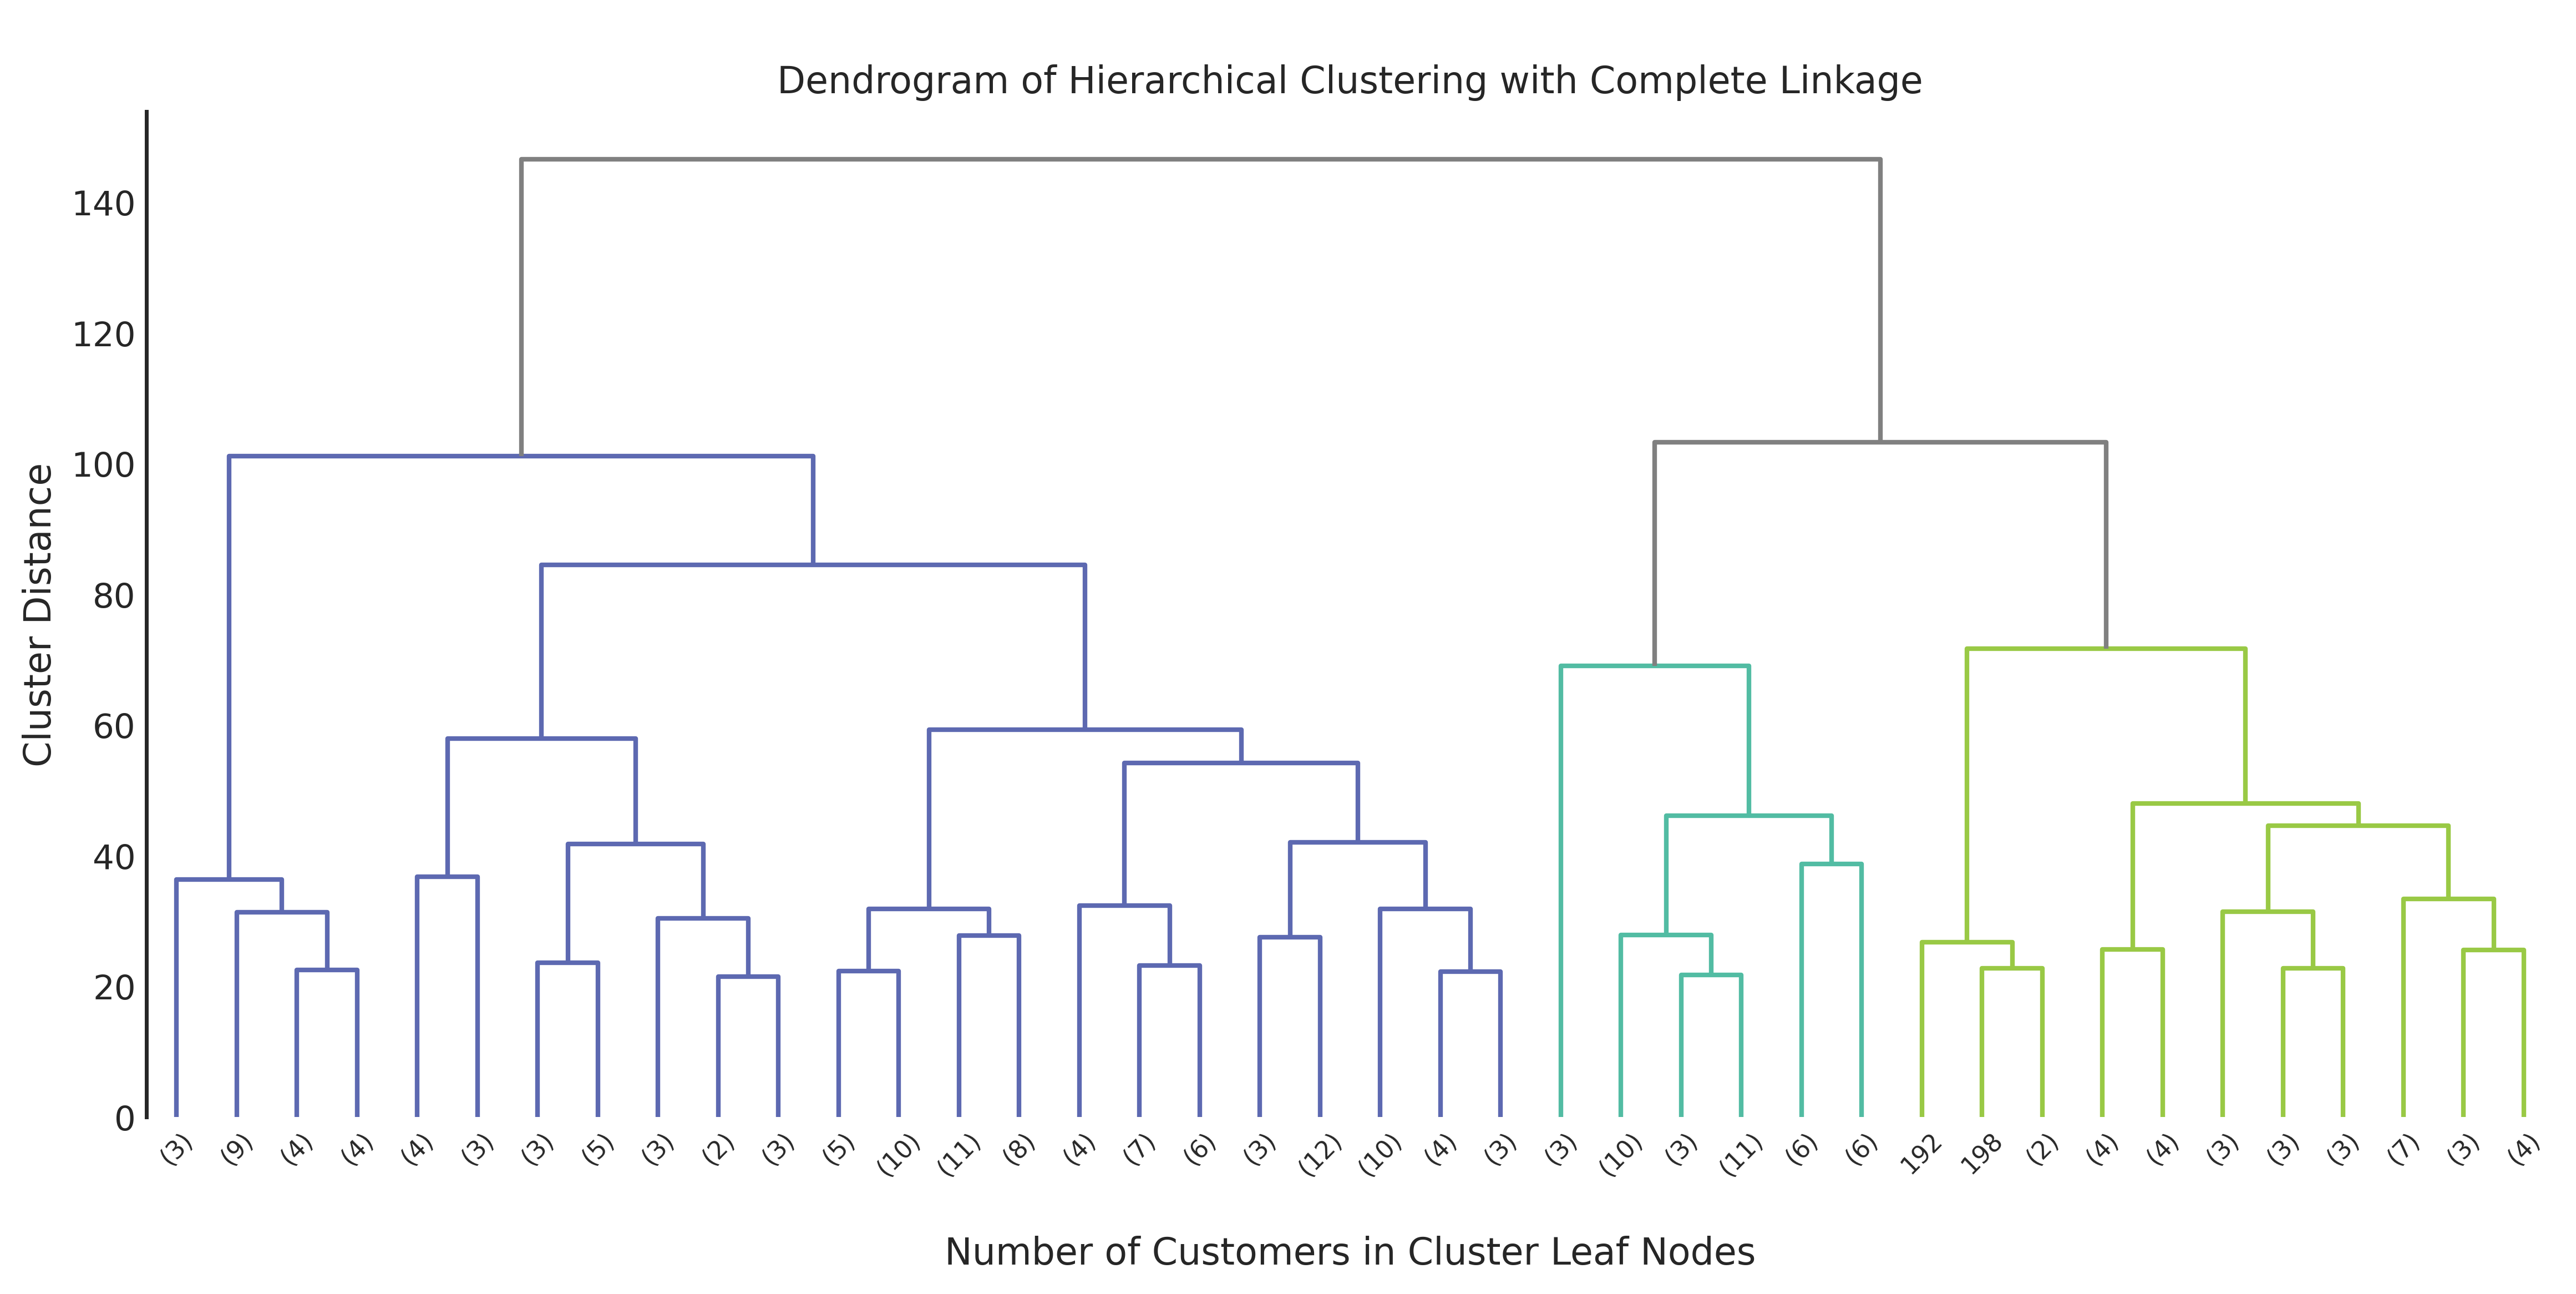

El dendrograma anterior muestra los grupos jerárquicos creados mediante el enlace completo, que une pares de grupos que tienen la distancia máxima más pequeña entre sus observaciones.
<br>La altura a la que se dividen las ramas indica la distancia entre los grupos. 
<br>Los grupos que son más similares entre sí se unen al principio del árbol y se vuelven cada vez menos similares a medida que ascendemos en el árbol. 
<br>Para identificar el número de grupos, podemos hacer un corte horizontal a través del dendrograma.
<br>Por ejemplo, si tuviéramos que cortar el dendrograma a una altura de 100, tendríamos unos tres grupos, con la mayoría de los clientes en el primer grupo, de color púrpura. 

In [206]:
# Hierarchical clustering
hc = AgglomerativeClustering(3, affinity='euclidean', linkage='complete', compute_full_tree=False)
hc_pred = hc.fit_predict(plot_df1)
plot_hc=plot_df1.copy()
plot_hc["Hierarchical Cluster"]=hc_pred
plot_hc=plot_hc.sort_values(by='Hierarchical Cluster')
plot_hc['Hierarchical Cluster'] = plot_hc['Hierarchical Cluster'].astype(str)

# Plot of clusters                                               
fig = px.scatter(plot_hc, x="clean_Ventas", y="clean_Beneficio_por_pedido", color="Hierarchical Cluster",
                 color_discrete_sequence=px.colors.qualitative.Vivid[1:])
fig.update_traces(marker=dict(size=11, opacity=0.75, line=dict(width=1, color='#F7F7F7')))
fig.update_layout(template=temp, title="Hierarchical Cluster Profiles,<br>Ventas vs. Beneficio por Pedido", 
                  width=700, legend_title = 'Cluster',
                  xaxis=dict(title='Ventas',showline=True, zeroline=False), 
                  yaxis=dict(title='Beneficio por Pedido, $',ticksuffix='k',showline=True))
fig.show()

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead



Detalle del grafico:<br>
En el centro del grafico se encuentra el grupo 2 con los beneficios en rangos de 4 y 6 BK
<br>El grupo 0 en la parte superior con los valores mayores
<br>y el grupo 1 en la parte inferior con los valores menores

# DBSCAN

La técnica de agrupación en clústeres espaciales basada en la densidad de aplicaciones con ruido (DBSCAN). 
<br>DBSCAN segmenta los datos en función de la densidad de las observaciones, donde las áreas de alta densidad se separan de las áreas de baja densidad. 
<br>El modelo también puede identificar clústeres de formas únicas y detectar valores atípicos dentro de los datos, aunque es sensible a las densidades variables de las observaciones.

In [207]:
# DB Scan clustering
db=DBSCAN(eps=15, min_samples=11, metric='euclidean')  #17,15 14,7 12 7 115
db_preds=db.fit_predict(plot_df1)
plot_db=plot_df1.copy()
plot_db['DB Cluster'] = db_preds
plot_db=plot_db.sort_values(by='DB Cluster')
plot_db['DB Cluster'] = plot_db['DB Cluster'].astype(str).apply(lambda x: 'Outliers' if x == '-1' else x)


# Plot of clusters   
fig = px.scatter(plot_db, x="clean_Ventas", y="clean_Beneficio_por_pedido", color="DB Cluster",
                 color_discrete_sequence=px.colors.qualitative.T10[2:])
fig.update_traces(marker=dict(size=11, opacity=0.85, line=dict(width=1, color='#F7F7F7')))
fig.update_layout(template=temp, title="DBSCAN Cluster Profiles,<br>Ventas vs. Beneficio_por_pedido", 
                  width=700, legend_title = 'Cluster',
                  xaxis=dict(title='Ventas',showline=True, zeroline=False), 
                  yaxis=dict(title='Beneficio_por_pedido, $',ticksuffix='k',showline=True))
fig.show()

Estos segmentos se asemejan a los clústeres del modelo K-Means, con los valores atípicos identificados en rojo.
En general, hay bastantes valores atípicos en el gráfico, lo que probablemente se deba a la variación en las densidades de los clústeres.

# Comparación de perfiles de clúster
A continuación se muestran los gráficos de los perfiles de los clientes en función de ventas y beneficios de cada modelo de agrupación.

In [208]:
# Initializing figure with 3 3D subplots
fig = make_subplots(rows=3, cols=1,
                    vertical_spacing=0.1,
                    specs=[[{'type': 'scatter3d'}],
                           [{'type': 'scatter3d'}], 
                           [{'type': 'scatter3d'}]],
                     subplot_titles=("K-Means Clustering with 5 clusters", 
                                     "Hierarchical Clustering<br>with 3 clusters", 
                                     "DBSCAN<br>with 4 clusters")
                   )

# Adding clusters to scatterplots 
plot_km['K-Means Cluster'] = plot_km['K-Means Cluster'].astype(int)
plot_km=plot_km.sort_values(by='K-Means Cluster')
for i in range(0,5):
    fig.add_trace(go.Scatter3d(x = plot_km[plot_km['K-Means Cluster'] == i]['clean_Ventas'],
                               y = plot_km[plot_km['K-Means Cluster'] == i]['clean_Beneficio_por_pedido'],
                               z = plot_km[plot_km['K-Means Cluster'] == i]['IDCliente'],                        
                               mode = 'markers', marker=dict(
                                   size=7,  
                                   color = px.colors.qualitative.Prism[i],
                                   line_width = 1,
                                   line_color='#F7F7F7',
                                   opacity=0.7),
                               name = str('Cluster '+str(i)), legendgroup = 1),
                 row=1, col=1)

plot_hc['Hierarchical Cluster'] = plot_hc['Hierarchical Cluster'].astype(int)
plot_hc=plot_hc.sort_values(by='Hierarchical Cluster')
for i in range(0,3):    
    fig.add_trace(go.Scatter3d(x = plot_hc[plot_hc['Hierarchical Cluster'] == i]['clean_Ventas'],
                               y = plot_hc[plot_hc['Hierarchical Cluster'] == i]['clean_Beneficio_por_pedido'],
                               z = plot_hc[plot_hc['Hierarchical Cluster'] == i]['IDCliente'],                        
                               mode = 'markers', marker=dict(
                                   size=7,   
                                   color = px.colors.qualitative.Vivid[i+1],
                                   line_width = 1, 
                                   line_color='#F7F7F7',
                                   opacity=0.7),
                               name = str('Hierarchical Cluster '+str(i)), legendgroup = 2), 
                  row=2, col=1)

for i, j in enumerate(plot_db['DB Cluster'].unique()): 
    fig.add_trace(go.Scatter3d(x = plot_db[plot_db['DB Cluster'] == j]['clean_Ventas'],
                               y = plot_db[plot_db['DB Cluster'] == j]['clean_Beneficio_por_pedido'],
                               z = plot_db[plot_db['DB Cluster'] == j]['IDCliente'], 
                               mode = 'markers', marker=dict(
                                   size=7,   
                                   color = px.colors.qualitative.T10[i+2],
                                   line_width = 1,
                                   line_color='#F7F7F7',
                                   opacity=0.8),
                               name = str('DB Cluster '+str(j)), legendgroup = 3), 
                  row=3, col=1)

fig.update_traces(hovertemplate='Beneficio_por_pedido: %{x}<br>Ventas: $%{z}<br>IDCliente: %{y}')
fig.update_layout(title="Segmento de Clientes segun: Ventas, beneficio por pedido",
                  template=temp, height=1800, legend_tracegroupgap = 500,
                  scene=dict(aspectmode='cube',
                             xaxis = dict(title='Ventas', 
                                          backgroundcolor="#F3F3F3",
                                          gridcolor="white",
                                          showbackground=True,
                                          zerolinecolor="white",),
                             yaxis = dict(title='$,Beneficio por pedido',
                                          backgroundcolor="#E4E4E4",
                                          gridcolor="white",
                                          showbackground=True,
                                          zerolinecolor="white"),
                             zaxis = dict(title='IDCliente', 
                                          ticksuffix='k',
                                          backgroundcolor="#F6F6F6",
                                          gridcolor="white",
                                          showbackground=True,
                                          zerolinecolor="white")), 
                  scene2=dict(aspectmode='cube', 
                             xaxis = dict(title='Ventas',
                                          backgroundcolor="#F3F3F3",
                                          gridcolor="white",
                                          showbackground=True,
                                          zerolinecolor="white",),
                             yaxis = dict(title='$, Beneficio_por_pedido',
                                          backgroundcolor="#E4E4E4",
                                          gridcolor="white",
                                          showbackground=True,
                                          zerolinecolor="white"),
                             zaxis = dict(title='IDCliente', 
                                          ticksuffix='k',
                                          backgroundcolor="#F6F6F6",
                                          gridcolor="white",
                                          showbackground=True,
                                          zerolinecolor="white")), 
                  scene3=dict(aspectmode='cube', 
                             xaxis = dict(title='Ventas',
                                          backgroundcolor="#F3F3F3",
                                          gridcolor="white",
                                          showbackground=True,
                                          zerolinecolor="white",),
                             yaxis = dict(title='$, Beneficio_por_pedido',
                                          backgroundcolor="#E4E4E4",
                                          gridcolor="white",
                                          showbackground=True,
                                          zerolinecolor="white"),
                             zaxis = dict(title='IDCliente', 
                                          ticksuffix='k',
                                          backgroundcolor="#F6F6F6",
                                          gridcolor="white",
                                          showbackground=True,
                                          zerolinecolor="white"))
                  )
fig.show()


# Conclusion

En este análisis, se desarrollaron tres modelos de agrupamiento para explorar diferentes tipos de clientes: K-Means Clustering, Hierarchical Clustering y DBSCAN. 
<br>Cada modelo identificó distintos segmentos de clientes....... 
<br>De las tres técnicas de agrupación,
<br>el modelo K-Means ...falta
<br> DBSCAN creó un modelo más simple con solo x clústeres e identificó los valores atípicos dentro de los datos. 

<br>El modelo de agrupación jerárquica definió el menor número de clústeres en general, con más énfasis en los ingresos del cliente.



A partir de este analisis, se podrian ejecutar acciones a fines de favorecer los segmentos de clientes que demuestren inconvenientes,,,,,,,,,,,,


